In [ ]:
import os
import sys
import pandas as pd
import argparse
import warnings
from utils import *
from torch import nn
import copy
from tqdm import tqdm
import random 
from data_loader import *
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import numpy as np
from http import HTTPStatus
import dashscope
from xgboost import XGBRegressor
from dashscope import Generation
import json
# import openai
from deepseek import DeepSeekClient
import os
from train import *
from model import GurobiPowerScheduler
import pickle
from together import Together
from openai import OpenAI
warnings.filterwarnings("ignore")
#set deepseek and openai API keys


dashscope.api_key = 'YOUR KEY'
DEEPSEEK_API_KEY = 'YOUR KEY'
OPENAI_API_KEY = 'YOUR KEY'
LLAMA_API_KEY= 'YOUR KEY'

In [32]:
parser_train = argparse.ArgumentParser()
parser_train.add_argument('--seq_len', type=int, default=24*7)
parser_train.add_argument('--pred_len', type=int, default=24)
parser_train.add_argument('--label_len', type=int, default=0)
parser_train.add_argument('--train_length', type=int, default=17376)
parser_train.add_argument('--target', type=str, default='target')
parser_train.add_argument('--scale', type=bool, default=True)
parser_train.add_argument('--inverse', type=bool, default=True)
parser_train.add_argument('--num_epochs', type=int, default=1000)
parser_train.add_argument('--mode', type=str, default='seq2seq')
parser_train.add_argument('--quantiles', type=list, default=[0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95])
parser_train.add_argument('--lr', type=float, default=1e-3)
parser_train.add_argument('--patience', type=int, default=5)
parser_train.add_argument('--hidden_layers', type=list, default=[128,128,128])
parser_train.add_argument('--e2e_num_epochs', type=int, default=5)
parser_train.add_argument('--e2e_ft_lr', type=float, default=1e-6)
parser_train.add_argument('--e2e_lr', type=float, default=1e-7)#1e-7
parser_train.add_argument('--ft_lr', type=float, default=1e-4)
parser_train.add_argument('--batch_size', type=int, default=16)
parser_train.add_argument('--device', type=str, default='cuda:0' if torch.cuda.is_available() else 'cpu')
parser_train.add_argument('--epsion_p', type=float, default=1e1)
parser_train.add_argument('--epsion_l', type=float, default=1e1)
parser_train.add_argument('--metric_list', type=list, default=['pinball_loss','winkler_score_0.1','MAE','RMSE'])


parser_train.add_argument('--N_g', type=int, default=3)
parser_train.add_argument('--T', type=int, default=24)
parser_train.add_argument('--N', type=int, default=25)
parser_train.add_argument('--x_max', type=int, default=[1500,1800,2000])
parser_train.add_argument('--x_min', type=int, default=[0,0,0])
parser_train.add_argument('--z_pos_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_neg_max', type=list, default=[500,700,800])
parser_train.add_argument('--z_pos_min', type=int, default=0)
parser_train.add_argument('--z_neg_min', type=int, default=0)
parser_train.add_argument('--r_neg', type=int, default=[800,800,500])
parser_train.add_argument('--r_pos', type=int, default=[800,800,500])
parser_train.add_argument('--alpha', type=list, default=[0.03 for i in range(24)]+[0.028 for i in range(24)]+[0.032 for i in range(24)])
parser_train.add_argument('--alpha_pos', type=list, default=[0.02 for i in range(24)]+[0.018 for i in range(24)]+[0.022 for i in range(24)])
parser_train.add_argument('--alpha_neg', type=list, default=[0.01 for i in range(24)]+[0.009 for i in range(24)]+[0.011 for i in range(24)])

parser_train.add_argument('--rho_z_pos', type=list, default=[0.05 for i in range(24)]+[0.045 for i in range(24)]+[0.055 for i in range(24)])
parser_train.add_argument('--rho_z_neg', type=list, default=[0.01 for i in range(24)]+[0.008 for i in range(24)]+[0.012 for i in range(24)])

parser_train.add_argument('--rho_r_pos', type=list, default=[0.1 for i in range(24)])
parser_train.add_argument('--rho_r_neg', type=list, default=[0.05 for i in range(24)])

parser_train.add_argument('--price_ratio_large', type=float, default=2.5)
parser_train.add_argument('--price_ratio_small', type=float, default=0.8)
parser_train.add_argument('--flag_dynamic_price', type=bool, default=False)
parser_train.add_argument('--flag_dynamic_mode', type=int, default=0)
parser_train.add_argument('--upper_quantiles', type=float, default=0.95)
parser_train.add_argument('--lower_quantiles', type=float, default=0.05)
parser_train.add_argument('--epsion', type=float, default=1)
parser_train.add_argument('--LLM_type', type=str, default='Llama') #'euclidean' 'manhattan'
args = parser_train.parse_args(args=[])

In [33]:
train_load_data,train_load_loader=get_load_data(args,flag='train')
val_load_data,val_load_loader=get_load_data(args,flag='val')
test_load_data,test_load_loader=get_load_data(args,flag='test')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

X_test=train_load_data.inverse_transform_X(test_load_data.X)
X_train=train_load_data.inverse_transform_X(train_load_data.X)
X_val=train_load_data.inverse_transform_X(val_load_data.X)
history_X_test=X_test[:,3:99]
history_X_train=X_train[:,3:99]
history_X_val=X_val[:,3:99]
print(np.shape(X_test))
print(np.shape(history_X_test))
print(np.shape(X_train))
print(np.shape(history_X_train))
print(np.shape(X_val))
print(np.shape(history_X_val))

(26113, 219)
(26113, 219)
(26113, 219)
(29, 195)
(29, 96)
(358, 195)
(358, 96)
(335, 195)
(335, 96)


In [34]:
from utils import *
combined_train_data,combined_train_loader,combined_val_data,combined_val_loader,combined_test_data,combined_test_loader,combined_fine_tune_data,combined_fine_tune_loader = obtain_price(args,train_load_data,val_load_data,test_load_data)
data_iter = iter(combined_test_loader)
input_load_test, labels_load_test, alpha_test, alpha_z_test, rho_z_test, rho_r_test = next(data_iter)

alpha_sample=alpha_test[0,:].detach().cpu().numpy()
alpha_z_sample=alpha_z_test[0,:].detach().cpu().numpy()
rho_z_sample=rho_z_test[0,:].detach().cpu().numpy()
rho_r_sample=rho_r_test[0,:].detach().cpu().numpy()

optimization_module = GurobiPowerScheduler(args, alpha_sample, alpha_z_sample, rho_z_sample, rho_r_sample)

x_max_list (72,)
r_pos_list (69,)
r_neg_list (69,)
[1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]


In [35]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
input_size=train_load_data.X.shape[-1]

set_seed(42)
output_size=24
#objective='reg:squarederror',
model_xgb = MultiOutputRegressor(XGBRegressor(
    max_depth=3,           # 降低树深度（默认6，建议3-5）
    min_child_weight=5,    # 叶子节点最小样本权重和（防止过细分裂）
    gamma=0.01,            # 分裂最小损失下降（越大越保守）
    reg_lambda=5,        # L2正则化（默认1，可增大）
    n_estimators=50
)
)
model_xgb.fit(train_load_data.X, train_load_data.y)

test_pred_nor=model_xgb.predict(test_load_data.X)
test_pred= train_load_data.inverse_transform(test_pred_nor)
test_actual_nor=test_load_data.y#.reshape(-1,1)
actual_load_test = train_load_data.inverse_transform(test_actual_nor)

cost_list_test=[]
cost_list_ideal=[]
for i in range(len(test_pred)):
    forecast=test_pred[i]
    actual=actual_load_test[i]
    _,_,costs_org=optimization_module.forward(forecast, actual)
    _,_,costs_ideal=optimization_module.forward(actual, actual)
    cost_list_test.append(costs_org)
    cost_list_ideal.append(costs_ideal)
    

print(MAE(test_pred,actual_load_test),RMSE(test_pred,actual_load_test),MAPE(test_pred,actual_load_test))

142.49279504534843 181.69046965491634 0.040117127187335976


In [36]:


class DeterministicLayer:
    def __init__(self, args):
        """日前调度层初始化"""
        self.T = args.T
        self.N_g = args.N_g
        self.N = args.N
        
        # 转换参数为NumPy数组
        self.x_max = np.array(args.x_max, dtype=np.float64)
        self.x_min = np.array(args.x_min, dtype=np.float64)
        print(self.x_max)
        print(self.x_min)
        self.r_pos = np.array(args.r_pos, dtype=np.float64)
        self.r_neg = np.array(args.r_neg, dtype=np.float64)
        self.z_pos_max = np.array(args.z_pos_max, dtype=np.float64)
        self.z_neg_max = np.array(args.z_neg_max, dtype=np.float64)
        self.min_up_time = np.array(args.min_up_time, dtype=np.int32)  # 最小开机时间
        
        # 预计算约束矩阵
        self._precompute_matrices()
    
    def _precompute_matrices(self):
        """预计算所有约束矩阵（完全对应CVXPY版本）"""
        T = self.T
        N_g = self.N_g
        
        # 单位矩阵
        I_N_g = np.eye(N_g * T, dtype=np.float64)
        I = np.eye(T, dtype=np.float64)
        
        # Ramp矩阵 (T-1) x T
        Ramp_matrix = np.zeros((T - 1, T), dtype=np.float64)
        for i in range(T - 1):
            Ramp_matrix[i, i] = 1
            if i + 1 < T:
                Ramp_matrix[i, i + 1] = -1
        
        # Ramp_matrix_combined: 3(T-1) x 3T
        zero_block = np.zeros((T - 1, T), dtype=np.float64)
        Ramp_matrix_combined = np.vstack([
            np.hstack([Ramp_matrix, zero_block, zero_block]),
            np.hstack([zero_block, Ramp_matrix, zero_block]),
            np.hstack([zero_block, zero_block, Ramp_matrix])
        ])
        
        # I_combined: T x 3T
        I_combined = np.hstack([I, I, I])
        
        # A_eq_l (功率平衡约束矩阵)
        self.A_eq_l = I_combined
        
        # A_uq_x (发电机约束矩阵)
        row1 = I_N_g
        row2 = Ramp_matrix_combined
        row3 = -Ramp_matrix_combined
        self.A_uq_x = np.vstack([row1, row2,row3])
        
        x_max_list=np.zeros(N_g * T, dtype=np.float64)
        for i in range(N_g):
             x_max_list[i*T:(i+1)*T] = self.x_max[i]*np.ones(T, dtype=np.float64)
    
    def solve(self, l_for, alpha, alpha_z):
        # 转换输入为NumPy数组并确保非负
        l_for = np.asarray(l_for, dtype=np.float64)
        alpha = np.asarray(alpha, dtype=np.float64)
        alpha_z = np.asarray(alpha_z, dtype=np.float64)
        
        # 创建Gurobi模型
        model = gp.Model("day_ahead_scheduling")
        model.setParam('OutputFlag', 0)  # 关闭输出
        
        # 添加决策变量
        x = model.addMVar(self.N_g * self.T, lb=0.0, name="x")
        z_max = model.addMVar(2 * self.N_g * self.T, lb=0.0, name="z_max")
        #u = model.addMVar(self.N_g * self.T, vtype=GRB.BINARY, name="u")  # 机组启停状态
        
        # 原有约束
        model.addConstr(self.A_eq_l @ x == l_for, "power_balance")
                    
        for g in range(self.N_g):
            for t in range(self.T):
                idx = g * self.T + t
                model.addConstr(x[idx] <= self.x_max[g], f"on_off_upper_{g}_{t}")
                model.addConstr(x[idx] >= self.x_min[g], f"on_off_lower_{g}_{t}")
                model.addConstr(x[idx] + z_max[idx] <= self.x_max[g], f"non_negative_{g}_{t}")
                model.addConstr(x[idx] - z_max[self.N_g * self.T + idx] >= self.x_min[g], f"non_negative_{g}_{t}")
                model.addConstr(z_max[idx] <= self.z_pos_max, f"z_pos_non_negative_{g}_{t}")
                model.addConstr(z_max[self.N_g * self.T + idx] <= self.z_neg_max, f"z_neg_non_negative_{g}_{t}")
                if t > 0:
                    model.addConstr(x[idx]-x[idx-1] <= self.r_pos[g], f"ramp_up_{g}_{t}")
                    model.addConstr(x[idx-1]-x[idx] <= self.r_neg[g], f"ramp_down_{g}_{t}")

        obj = alpha @ x +  alpha_z @ z_max
        model.setObjective(obj, GRB.MINIMIZE)
        
        # 求解
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            return x.X, z_max.X, u.X
        else:
            raise RuntimeError(f"日前调度优化失败，状态码: {model.status}")


In [37]:
class DeterministicLayer_milp:
    def __init__(self, args):
        """日前调度层初始化"""
        self.T = args.T
        self.N_g = args.N_g
        self.N = args.N
        
        # 转换参数为NumPy数组
        self.x_max = np.array(args.x_max, dtype=np.float64)
        self.x_min = np.array(args.x_min, dtype=np.float64)
        print(self.x_max)
        print(self.x_min)
        self.r_pos = np.array(args.r_pos, dtype=np.float64)
        self.r_neg = np.array(args.r_neg, dtype=np.float64)
        self.z_pos_max = np.array(args.z_pos_max, dtype=np.float64)
        self.z_neg_max = np.array(args.z_neg_max, dtype=np.float64)
        self.min_up_time = np.array(args.min_up_time, dtype=np.int32)  # 最小开机时间
        
        # 预计算约束矩阵
        self._precompute_matrices()
    
    def _precompute_matrices(self):
        """预计算所有约束矩阵（完全对应CVXPY版本）"""
        T = self.T
        N_g = self.N_g
        
        # 单位矩阵
        I_N_g = np.eye(N_g * T, dtype=np.float64)
        I = np.eye(T, dtype=np.float64)
        
        # Ramp矩阵 (T-1) x T
        Ramp_matrix = np.zeros((T - 1, T), dtype=np.float64)
        for i in range(T - 1):
            Ramp_matrix[i, i] = 1
            if i + 1 < T:
                Ramp_matrix[i, i + 1] = -1
        
        # Ramp_matrix_combined: 3(T-1) x 3T
        zero_block = np.zeros((T - 1, T), dtype=np.float64)
        Ramp_matrix_combined = np.vstack([
            np.hstack([Ramp_matrix, zero_block, zero_block]),
            np.hstack([zero_block, Ramp_matrix, zero_block]),
            np.hstack([zero_block, zero_block, Ramp_matrix])
        ])
        
        # I_combined: T x 3T
        I_combined = np.hstack([I, I, I])
        
        # A_eq_l (功率平衡约束矩阵)
        self.A_eq_l = I_combined
        
        # A_uq_x (发电机约束矩阵)
        row1 = I_N_g
        row2 = Ramp_matrix_combined
        row3 = -Ramp_matrix_combined
        self.A_uq_x = np.vstack([row1, row2,row3])
        
        x_max_list=np.zeros(N_g * T, dtype=np.float64)
        for i in range(N_g):
             x_max_list[i*T:(i+1)*T] = self.x_max[i]*np.ones(T, dtype=np.float64)
    
    def solve(self, l_for, alpha, alpha_z):
        # 转换输入为NumPy数组并确保非负
        l_for = np.asarray(l_for, dtype=np.float64)
        alpha = np.asarray(alpha, dtype=np.float64)
        alpha_z = np.asarray(alpha_z, dtype=np.float64)
        
        # 创建Gurobi模型
        model = gp.Model("day_ahead_scheduling")
        model.setParam('OutputFlag', 0)  # 关闭输出
        
        # 添加决策变量
        x = model.addMVar(self.N_g * self.T, lb=0.0, name="x")
        z_max = model.addMVar(2 * self.N_g * self.T, lb=0.0, name="z_max")
        u = model.addMVar(self.N_g * self.T, vtype=GRB.BINARY, name="u")  # 机组启停状态
        
        # 原有约束
        model.addConstr(self.A_eq_l @ x == l_for, "power_balance")
        
        # 添加最小开机时间约束
        for g in range(self.N_g):
            min_up = self.min_up_time
            for t in range(self.T):
                end_time = min(t + min_up - 1, self.T - 1)
                for k in range(t, end_time + 1):
                    model.addConstr(u[g * self.T + k] >= u[g * self.T + t] - (1 if t > 0 else 0) * u[g * self.T + t - 1], 
                                  f"min_up_{g}_{t}_{k}")
                    
        for g in range(self.N_g):
            for t in range(self.T):
                idx = g * self.T + t
                model.addConstr(x[idx] <= self.x_max[g] * u[idx], f"on_off_upper_{g}_{t}")
                model.addConstr(x[idx] >= self.x_min[g] * u[idx], f"on_off_lower_{g}_{t}")
                model.addConstr(x[idx] + z_max[idx] <= self.x_max[g] * u[idx], f"non_negative_{g}_{t}")
                model.addConstr(x[idx] - z_max[self.N_g * self.T + idx] >= self.x_min[g] * u[idx], f"non_negative_{g}_{t}")
                model.addConstr(z_max[idx] <= self.z_pos_max * u[idx], f"z_pos_non_negative_{g}_{t}")
                model.addConstr(z_max[self.N_g * self.T + idx] <= self.z_neg_max * u[idx], f"z_neg_non_negative_{g}_{t}")
                if t > 0:
                    model.addConstr(x[idx]-x[idx-1] <= self.r_pos[g], f"ramp_up_{g}_{t}")
                    model.addConstr(x[idx-1]-x[idx] <= self.r_neg[g], f"ramp_down_{g}_{t}")

        obj = alpha @ x +  alpha_z @ z_max
        model.setObjective(obj, GRB.MINIMIZE)
        
        # 求解
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            return x.X, z_max.X, u.X
        else:
            raise RuntimeError(f"日前调度优化失败，状态码: {model.status}")


In [38]:


class IntraScheduleLayer:
    def __init__(self, args):
        """日内调度层初始化"""
        self.T = args.T
        self.N = args.N
        self.N_g = args.N_g
        
        # 预计算约束矩阵
        self._precompute_matrices()
    
    def _precompute_matrices(self):
        T = self.T
        N_g = self.N_g
        
        # 单位矩阵
        I_N_g = np.eye(N_g * T, dtype=np.float64)
        I = np.eye(T, dtype=np.float64)
        
        # I_combined: T x 3*N_g*T
        self.I_combined = np.hstack([I, I, I])
        
        # F_eq_r: T x 2T
        self.F_eq_r = np.hstack([I, -I])
        
        # F_eq_z: T x 2*N_g*T
        self.F_eq_z = np.hstack([self.I_combined, -self.I_combined])
        
        # G_eq_l: T x T
        self.G_eq_l = I
        
        # h_eq: T
        self.h_eq = np.zeros(T, dtype=np.float64)
        
        # F_uq: 2*N_g*T x 2*N_g*T
        row1 = np.hstack([I_N_g, np.zeros((N_g * T, N_g * T), dtype=np.float64)])
        row2 = np.hstack([np.zeros((N_g * T, N_g * T), dtype=np.float64), I_N_g])
        self.F_uq = np.vstack([row1, row2])
    
    def solve(self, z_max, l_for, target_l, rho_z, rho_r):
        # 转换输入为NumPy数组
        z_max = np.asarray(z_max, dtype=np.float64).flatten()
        l_for = np.asarray(l_for, dtype=np.float64).flatten()
        target_l = np.asarray(target_l, dtype=np.float64).flatten()
        rho_z = np.asarray(rho_z, dtype=np.float64).flatten()
        rho_r = np.asarray(rho_r, dtype=np.float64).flatten()
        
        # 计算负荷误差
        error_l = l_for - target_l
        
        # 创建Gurobi模型
        model = gp.Model("intra_day_scheduling")
        model.setParam('OutputFlag', 0)  # 关闭输出
        
        # 添加决策变量
        z = model.addMVar(2 * self.N_g * self.T, lb=0.0, name="z")
        r = model.addMVar(2 * self.T, lb=0.0, name="r")
        
        # 约束1: F_uq @ z <= z_max (备用容量限制)
        model.addConstr(self.F_uq @ z <= z_max, "reserve_limit")
        
        # 约束2: F_eq_z @ z + G_eq_l @ error_l + F_eq_r @ r == h_eq (功率平衡)
        model.addConstr(
            self.F_eq_z @ z + self.G_eq_l @ error_l + self.F_eq_r @ r == self.h_eq,
            "power_balance"
        )
        
        # 目标函数: rho_z @ z + rho_r @ r
        obj = rho_z @ z + rho_r @ r
        model.setObjective(obj, GRB.MINIMIZE)
        
        # 求解
        model.optimize()
        
        if model.status == GRB.OPTIMAL:
            return z.X, r.X
        else:
            raise RuntimeError(f"日内调度优化失败，状态码: {model.status}")


In [39]:
val_pred_nor=model_xgb.predict(val_load_data.X)
val_pred = train_load_data.inverse_transform(val_pred_nor)
val_actual_nor=val_load_data.y#.reshape(-1,1)
actual_load_val = train_load_data.inverse_transform(val_actual_nor)

cost_list_val=[]
cost_list_val_ideal=[]
for i in range(len(val_pred)):
    forecast=val_pred[i]
    actual=actual_load_val[i]
    _,_,costs_org=optimization_module.forward(forecast, actual)
    _,_,costs_ideal=optimization_module.forward(actual, actual)
    cost_list_val.append(costs_org)
    cost_list_val_ideal.append(costs_ideal)

print(MAE(val_pred,actual_load_val),RMSE(val_pred,actual_load_val),MAPE(val_pred,actual_load_val))


train_pred_nor=model_xgb.predict(train_load_data.X)
train_pred = train_load_data.inverse_transform(train_pred_nor)
train_actual_nor=train_load_data.y#.reshape(-1,1)
actual_load_train = train_load_data.inverse_transform(train_actual_nor)

cost_list_train=[]
cost_list_train_ideal=[]
for i in range(len(train_pred)):
    forecast=train_pred[i]
    actual=actual_load_train[i]
    _,_,costs_org=optimization_module.forward(forecast, actual)
    _,_,costs_ideal=optimization_module.forward(actual, actual)
    cost_list_train.append(costs_org)
    cost_list_train_ideal.append(costs_ideal)

print(MAE(train_pred,actual_load_train),RMSE(train_pred,actual_load_train),MAPE(train_pred,actual_load_train))

90.74887780336599 127.16092506028966 0.026737809014022222
59.09081991469172 79.51627355207512 0.01798264355907767


In [40]:
from E2E import E2E_test_ideal,E2E_test,E2E_train

In [41]:
from model import *
from E2E import *

In [42]:
import numpy as np

class CurveDictDB:
    def __init__(self):
        self.data = {}   # key: id, value: 记录字典
        self.curve_index = {}  # key: curve_key, value: list of ids

    def _curve_key(self, curve):
        # 使用 3 位小数防止浮点误差
        return tuple(round(x, 3) for x in curve)

    def insert(self, record):
        record_id = record['id']
        curve_key = self._curve_key(record['load'])

        if record_id in self.data:
            raise ValueError(f"id {record_id} 已存在，不能重复插入！")
        self.data[record_id] = record

        if curve_key not in self.curve_index:
            self.curve_index[curve_key] = []
        self.curve_index[curve_key].append(record_id)

    def get_top_k(self, curve_new, k=3, q=1, distance_type='euclidean', mode='good'):
        """
        查找相似负荷曲线 (不同于 curve_new)，分组后筛选并批量计算距离，返回前 k 条。
        """
        curve_new_key = self._curve_key(curve_new)
        grouped_records = {}

        # 基于索引和原始数据较快分组
        for curve_key, id_list in self.curve_index.items():
            if curve_key == curve_new_key:
                continue  # 跳过自身曲线
            records = [self.data[_id] for _id in id_list]
            grouped_records[curve_key] = []
            for record in records:
                # 保留你原来的筛选字段
                grouped_records[curve_key].append({
                    'id': record['id'],
                    'flag': record['flag'],
                    'prompt': record.get('prompt', ''),
                    'actual_load': record.get('actual_load', []),
                    'fine_tuned_load': record.get('fine_tuned_load', []),
                    'load': record['load'],
                    'cost': record['cost'],
                    'cost_reduction': record['cost_reduction']
                })

        # 模式筛选
        unique_records = []
        for curve_key, records in grouped_records.items():
            if mode == 'good':
                filtered_records = [r for r in records if r['cost_reduction'] >= 0]
                filtered_records.sort(key=lambda x: x['cost'])
            elif mode == 'bad':
                filtered_records = [r for r in records if r['cost_reduction'] < 0]
                filtered_records.sort(key=lambda x: x['cost'], reverse=True)
            else:
                raise ValueError(f"未知的mode: {mode}")
            unique_records.extend(filtered_records[:min(q, len(filtered_records))])

        if not unique_records:
            return []

        # 批量距离计算！
        loads_matrix = np.array([r['load'] for r in unique_records])
        curve_new_arr = np.array(curve_new)

        if distance_type == 'euclidean':
            dists = np.linalg.norm(loads_matrix - curve_new_arr, axis=1)
        elif distance_type == 'manhattan':
            dists = np.sum(np.abs(loads_matrix - curve_new_arr), axis=1)
        else:
            raise ValueError(f"未知的distance_type: {distance_type}")

        results = []
        for idx, record in enumerate(unique_records):
            results.append({
                'id': record['id'],
                'flag': record['flag'],
                'prompt': record.get('prompt', ''),
                'actual_load': record.get('actual_load', []),
                'fine_tuned_load': record.get('fine_tuned_load', []),
                'load': record['load'],
                'cost': record['cost'],
                'distance': dists[idx],
                'cost_reduction': record['cost_reduction']
            })

        results.sort(key=lambda x: x['distance'])
        return results[:min(k, len(results))]

    def get_top_k_same(self, curve_new, k=3, mode='good'):
        """
        查找与 curve_new 完全相同的负荷曲线记录，并按成本排序
        """
        curve_key = self._curve_key(curve_new)
        id_list = self.curve_index.get(curve_key, [])
        print(id_list)
        if not id_list:
            return []

        same_curve_records = [self.data[_id] for _id in id_list]
        base_record = next((r for r in same_curve_records if r['flag'] == 0), None)
        if base_record is None:
            return []

        base_cost = base_record['cost']
        filtered_records = []
        for record in same_curve_records:
            if mode == 'good' and record['cost'] < base_cost:
                filtered_records.append(record)
            elif mode == 'bad' and record['cost'] >= base_cost:
                filtered_records.append(record)

        filtered_records.sort(key=lambda x: x['cost'], reverse=(mode == 'bad'))
        return filtered_records[:k]

    def get_top_k_unique_loads(self, curve_new, k=3, q=1, distance_type='euclidean', mode='good'):
        """
        从 get_top_k 输出中选出负荷曲线不重复的前 k 条记录。
        """
        candidates = self.get_top_k(curve_new, k=max(20, k*2), q=q, distance_type=distance_type, mode=mode)
        unique_load_set = set()
        top_unique = []
        for r in candidates:
            load_key = tuple(round(x, 5) for x in r['load'])
            if load_key not in unique_load_set:
                unique_load_set.add(load_key)
                top_unique.append(r)
            if len(top_unique) == k:
                break
        return top_unique

    def rebuild_index(self):
        """从 self.data 重新扫描并生成 self.curve_index"""
        self.curve_index = {}
        for record_id, record in self.data.items():
            curve_key = self._curve_key(record['load'])
            if curve_key not in self.curve_index:
                self.curve_index[curve_key] = []
            self.curve_index[curve_key].append(record_id)


    def update(self, record_id, new_data):
        """
        更新指定 id 的实验记录
        """
        if record_id in self.data:
            self.data[record_id].update(new_data)
            return True
        return False

    def get_by_id(self, record_id):
        """
        根据 id 获取实验记录
        """
        return self.data.get(record_id)

    def all(self):
        """
        返回所有记录的列表
        """
        return list(self.data.values())


In [43]:
cost_list_test_insert=[cost_list_test[i]-cost_list_ideal[i] for i in range(len(cost_list_test))]
actual_load_test_insert=test_actual_nor
forecasts_load_test_insert=test_pred_nor

cost_list_train_insert=[cost_list_train[i]-cost_list_train_ideal[i] for i in range(len(cost_list_train))]
actual_load_train_insert=train_actual_nor
forecasts_load_train_insert=train_pred_nor

cost_list_val_insert=[cost_list_val[i]-cost_list_val_ideal[i] for i in range(len(cost_list_val))]
actual_load_val_insert=val_actual_nor
forecasts_load_val_insert=val_pred_nor

history_X_insert_train=[np.concatenate([history_X_train[i], train_pred[i]]) for i in range(len(train_pred))]
history_X_insert_val=[np.concatenate([history_X_val[i], val_pred[i]]) for i in range(len(val_pred))]
history_X_insert_test=[np.concatenate([history_X_test[i], test_pred[i]]) for i in range(len(test_pred))]

db_train = CurveDictDB()
cur_id_start = max(db_train.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load,history_X) in enumerate(zip(cost_list_train_insert, forecasts_load_train_insert,forecasts_load_train_insert, actual_load_train_insert,history_X_insert_train)):
    record = {
        'id': cur_id_start + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0, # 1代表成本比fine tune前低
        'history_X': history_X
    }
    db_train.insert(record)

db_val = CurveDictDB()
cur_id_start_val = max(db_val.data.keys(), default=0) + 1
for i, (cost, load, fine_tuned_load, actual_load, history_X) in enumerate(zip(cost_list_val_insert, forecasts_load_val_insert, forecasts_load_val_insert, actual_load_val_insert, history_X_insert_val)):
    record = {
        'id': cur_id_start_val + i,
        'flag': 0,
        'prompt': '',
        'load': load,
        'fine_tuned_load': fine_tuned_load,
        'cost': cost,
        'actual_load': actual_load,
        'cost_reduction': 0,
        'history_X': history_X
    }
    db_val.insert(record)


In [44]:
def generate_prompt_sys(args,data):
    # Return English prompt
    prompt = (
        f"You are a power dispatch expert. There are {args.N_g} generating units:\n"
        f"Unit 1: {args.x_min}~{args.x_max} MW, "
        f"Unit 2: {args.x_min}~{args.x_max} MW, "
        f"Unit 3: {args.x_min}~{args.x_max} MW.\n"
        f"Unit 1 generation cost: {args.alpha[0:args.T]}*x RMB/kWh, "
        f"Unit 2 generation cost: {args.alpha[args.T:2*args.T]}*x RMB/kWh, "
        f"Unit 3 generation cost: {args.alpha[args.T*2:args.T*3]}*x RMB/kWh.\n"
        f"Unit 1 positive reserve limit: {args.rho_z_pos[0:args.T]} RMB/kWh, "
        f"Unit 1 negative reserve limit: {args.rho_z_neg[0:args.T]} RMB/kWh.\n"
        f"Unit 2 positive reserve limit: {args.rho_z_pos[args.T:2*args.T]} RMB/kWh, "
        f"Unit 2 negative reserve limit: {args.rho_z_neg[args.T:2*args.T]} RMB/kWh.\n"
        f"Unit 3 positive reserve limit: {args.rho_z_pos[args.T*2:args.T*3]} RMB/kWh, "
        f"Unit 3 negative reserve limit: {args.rho_z_neg[args.T*2:args.T*3]} RMB/kWh.\n"   
    #    f"Predicted load: {data['load']}\n"
    )
    
    return prompt



In [45]:
data_iter = iter(combined_test_loader)
input_load_test, labels_load_test, alpha_test, alpha_z_test, rho_z_test, rho_r_test = next(data_iter)

alpha_sample=alpha_test[0,:].detach().cpu().numpy()
alpha_z_sample=alpha_z_test[0,:].detach().cpu().numpy()
rho_z_sample=rho_z_test[0,:].detach().cpu().numpy()
rho_r_sample=rho_r_test[0,:].detach().cpu().numpy()

optimization_module = GurobiPowerScheduler(args, alpha_sample, alpha_z_sample, rho_z_sample, rho_r_sample)

x_max_list (72,)
r_pos_list (69,)
r_neg_list (69,)
[1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500. 1500.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800. 1800.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.
 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000. 2000.]


In [46]:


output_require_prompt = """Please learn from the few-shot record and derived a combined strategy to adjust the original load curve.
    You can only change several time points, and each point can only be changed within ±10% of the original value.
    Output a Python function named "adjustment_strategy" that implements the optimization strategy. The function should take the original load curve as input and return a list of 24 delta values (changes to apply).

    Requirements:
    1. Define a function: def adjustment_strategy(original_load: list) -> list:
    2. The function must return a list of 24 numbers (deltas)
    3. Use only basic Python operations (no external libraries)
    4. Include comments explaining your strategy
    5. Example:
        def adjustment_strategy(original_load):
            deltas = []
            for i, load_val in enumerate(original_load):
                if 8 <= i < 18:
                    deltas.append(load_val * 0.05) 
                if 20 <= i <22:
                    deltas.append(-load_val * 0.03) 
            return deltas
    """

In [47]:

def get_fail_reflections_by_curve_distance(reflection_records, current_load, max_num=2):
    """
    根据和当前曲线的距离，选最近 max_num 个失败案例
    """
    # 只考虑 cost_after > cost_before 的反思
    fail_candidates = [r for r in reflection_records if r['cost_after'] > r['cost_before']]
    dist_list = []
    for r in fail_candidates:
        curve = np.array(r['original_load']).flatten()
        dist = np.linalg.norm(np.array(current_load).flatten() - curve)
        dist_list.append((dist, r))
    # 按距离升序排序
    dist_list.sort(key=lambda x: x[0])
    # 取距离最近的 max_num 个
    nearest_fail_records = [r for (_, r) in dist_list[:max_num]]
    return nearest_fail_records

### main

In [48]:
def few_shot_prompt_generate(args, similar_days, max_strategies=10, max_attempts=5,failure_strategy=None):  
    """  
    Generate few-shot prompts for small-scale adjustment strategies  
    Each adjustment modifies no more than 5 time points, gradually building a strategy library  
      
    Parameters:  
        args: Model parameters  
        db: Database connection object  
        similar_days: List of similar day data  
        max_strategies: Maximum number of valid strategies  
        max_attempts: Maximum number of attempts  
          
    Returns:  
        tuple: (Strategy history string, List of valid strategies)  
    """  
    # Get average load of similar days
    similar_day_load_nor = np.mean([day['load'] for day in similar_days], axis=0)  
    similar_day_actual_nor = np.mean([day['actual_load'] for day in similar_days], axis=0)  
      
    # Calculate original cost  
    similar_day_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_load_nor).reshape(1,-1))[0]  
    similar_day_actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(similar_day_actual_nor).reshape(1,-1))[0]  
    _, _, original_cost = optimization_module.forward(similar_day_load_numpy, similar_day_actual_load_numpy)  
    original_cost = original_cost.item()  
      
    # Strategy generation prompt template  
    sim_data = {"load": similar_day_load_nor}  
    system_prompt = generate_prompt_sys(args, sim_data)  
    higher_flag = "higher" if sum(np.array(similar_day_load_nor) - np.array(similar_day_actual_nor)) > 0 else "lower"  
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"  
    system_prompt += f"""\n The maximum load occurs at {int(np.argmax(similar_day_load_nor))} hour, and the minimum load occurs at {int(np.argmin(similar_day_load_nor))} hour.\n\n"""  
    system_prompt += f"""  
    You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In this case, the similar day forecast is {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """  

    if failure_strategy==None:
        pass
    else:
        system_prompt+='Here is failed strategy:\n'+failure_strategy


    output_require_prompt = f"""  
    You are an expert in electricity load curve optimization. Your task is to generate Python functions that implement small-scale optimization strategies for daily electricity load curves.  

    Requirements:  
    1. Generate exactly 10 distinct Python functions named "strategy_1", "strategy_2", "strategy_3", "strategy_4", "strategy_5", "strategy_6", "strategy_7", "strategy_8", "strategy_9", and "strategy_10".  
    2. The strategy should focus on a *different* part of the load curve, avoiding concentrating all changes in same time intervals.  
    2. Each function must:  
       - Take a single argument: the original load curve (list of 24 hourly values)  
       - Return a list of 24 numbers (deltas) representing adjustments to each hour  
    3. Each strategy must:  
       - Adjust no more than 5 time points (hours)  
       - Target adjacent hours (e.g., 7pm to 9pm)  
       - Keep adjustments within ±15% of the original value at each hour  
       - Try to be distinct from other strategies  
    4. Use only basic Python operations (no external libraries)  
    5. Include comments explaining:  
       - Which specific hours are targeted  
       - Why this strategy might reduce electricity costs  
    6. Example strategies:  

    Example 1: Reduce evening peak  
    def strategy_1(original_load):  
        # Focus: Reduce peak at 18:00 and 19:00 only  
        deltas = [0] * 24  
        # Only adjust hours 18 and 19  
        deltas[18] = -original_load[18] * 0.02  # Reduce by 2%  
        deltas[19] = -original_load[19] * 0.02  # Reduce by 2%  
        return deltas  

    Example 2: Shift load from afternoon to late afternoon  
    def strategy_2(original_load):  
        # Focus: Shift load from 14:00 to 15:00  
        deltas = [0] * 24  
        # Only adjust hours 14 and 15  
        deltas[14] = original_load[14] * 0.015  # Reduce at 14:00  
        deltas[15] = original_load[14] * 0.015   # Increase at 15:00  
        return deltas  

    Example 3: Increase off-peak consumption  
    def strategy_3(original_load):  
        # Focus: Slightly increase off-peak at 2:00 and 3:00  
        deltas = [0] * 24  
        # Only adjust hours 2 and 3  
        deltas[2] = original_load[2] * 0.03  # Increase by 3%  
        deltas[3] = original_load[3] * 0.03  # Increase by 3%  
        return deltas  

    Example 4: Flatten morning peak  
    def strategy_4(original_load):  
        # Focus: Reduce morning peak at 8:00 and shift to 9:00  
        deltas = [0] * 24  
        # Only adjust hours 8 and 9  
        deltas[8] = -original_load[8] * 0.05  # Reduce at 8:00  
        deltas[9] = original_load[8] * 0.05   # Increase at 9:00  
        return deltas  

    Example 5: Smooth transition between peak and off-peak  
    def strategy_5(original_load):  
        # Focus: Smooth transition from evening to night (20:00-21:00)  
        deltas = [0] * 24  
        # Only adjust hours 20 and 21  
        deltas[20] = -original_load[20] * 0.02  # Reduce at 20:00  
        deltas[21] = -original_load[20] * 0.02   # Increase at 21:00  
        return deltas  
    """  
      
    # Store valid strategies  
    valid_strategies = []  
    strategy_history = ""  
    attempt_count = 0  
    full_prompt = ''  
    while (len(valid_strategies) < max_strategies and attempt_count < max_attempts) or (len(valid_strategies) < int(max_strategies)/2 and attempt_count < 10):  
        attempt_count += 1  
        print(f"Strategy generation attempt #{attempt_count} (Current valid strategies: {len(valid_strategies)}/{max_strategies})")  
        if valid_strategies != []:  
            history_snippet = 'Here are some previously discovered effective small-scale adjustment strategies:\n, you can modify these strategies or generate new ones.\n'  
            for i in range(len(valid_strategies)):  
                history_snippet += (f"Strategy {i+1}:\n{valid_strategies[i]['code']}\n\n")  
        else:  
            history_snippet = "No previously discovered effective small-scale adjustment strategies."  
        if attempt_count >= int(max_attempts)/2:  
            print('Providing actual load values')  
            full_prompt += (f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"This is your FINAL attempt for this similar day. The actual load is {similar_day_actual_nor}. Use all your knowledge and experience to produce the best possible optimized load curves.\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        else:  
            full_prompt += (  
                            f"SYSTEM INSTRUCTIONS:\n{system_prompt}\n\n"  
                            f"HISTORICAL CONTEXT:\n{history_snippet}\n\n"  
                            f"TASK REQUIREMENTS:\n{output_require_prompt}\n\n")  
        try:  
            # Extract strategy code  
            if args.LLM_type == 'Qwen':  
                response = Generation.call(  
                model="qwen-plus",  
                messages=[  
                    {"role": "system", "content": full_prompt},  
                ],  
                parameters={  
                    "temperature": 0.5,  
                    "max_tokens": 1024,  
                    "top_k": 20  
                }  
                )  
                raw_text = response.output.text.strip()  
                func_code = extract_pure_code(raw_text)  

            elif args.LLM_type == 'Deepseek':  
                client = OpenAI(api_key=DEEPSEEK_API_KEY,  
                base_url="https://api.deepseek.com")  
                response = client.chat.completions.create(  
                    model="deepseek-chat",  
                    messages=[  
                        {"role": "system", "content": full_prompt},  
                    ],  
                    temperature=0.5,  
                    max_tokens=2048,  
                    stream=False,  
                )  
                raw_text = response.choices[0].message.content.strip()  
                func_code = extract_pure_code(raw_text)  
            
            elif args.LLM_type=='Llama':
                client = Together(api_key=LLAMA_API_KEY)
                response = client.chat.completions.create(
                    model="meta-llama/Llama-4-Scout-17B-16E-Instruct",  # 可替换为其他 Llama 版本
                    messages=[
                    {"role": "system", "content": full_prompt},
                ],
                temperature=1.2,
                max_tokens=2048,
                stream=False,
                )
                raw_text = response.choices[0].message.content.strip()
                func_code = extract_pure_code(raw_text)
  
  
            # Evaluate all strategy functions (separately)  
            strategy_results = evaluate_individual_strategies(  
                func_code,   
                similar_day_load_nor.tolist(),  
                max_change_percent=0.1  
            )  
              
            if not strategy_results:  
                print("No valid strategy functions generated")  
                continue  
                  
            for name, strategy in strategy_results.items():  
                try:  
                    # Apply strategy to similar day data  
                    adjusted_curve = strategy['adjusted_curve']  
                    adjusted_numpy =  train_load_data.scaler_y.inverse_transform(np.array(adjusted_curve).reshape(1,-1))[0]  
                      
                    # Calculate strategy cost  
                    _, _, strategy_cost = optimization_module.forward(adjusted_numpy, similar_day_actual_load_numpy)  
                    strategy_cost = strategy_cost.item()  
                      
                    # Check if cost is reduced  
                    if strategy_cost < original_cost - 1:  
                        # Check number of adjusted points  
                        adjusted_hours = sum(1 for delta in strategy['delta_curve'] if abs(delta) > 1e-5)  
                        if adjusted_hours <= 5:  # Ensure only 5 or fewer time points are adjusted  
                            valid_strategies.append({  
                                'name': 'Strategy ' + str(len(valid_strategies)+1),  
                                'code': strategy['func_code'],  
                                'cost_reduction': original_cost - strategy_cost,  
                                'final_cost': strategy_cost,  
                                'original_cost': original_cost,  
                                'original_load' : similar_day_load_nor.tolist(),  
                                'actual_load': similar_day_actual_nor.tolist(),  
                                'adjusted_curve': adjusted_curve,  
                                'adjusted_hours': adjusted_hours  
                            })  
                              
                            # Add to history  
                            strategy_history += (  
                                f"Strategy {name} reduced cost on similar day: {original_cost - strategy_cost:.2f}\n"  
                                f"Adjusted time points: {adjusted_hours} hours\n"  
                                f"Code:\n{strategy['func_code']}\n\n"  
                            )  
                              
                            print(f"Discovered valid strategy {name}, cost {strategy_cost:.2f}, original cost {original_cost:.2f}, (reduction {original_cost - strategy_cost:.2f})")  
                              
                            # Exit early if max strategies reached  
                            if len(valid_strategies) >= max_strategies:  
                                break  
                except Exception as e:  
                    print(f"Error evaluating strategy {name}: {str(e)}")  
          
        except Exception as e:  
            print(f"Strategy generation exception: {str(e)}")  
      
    # Add empty strategy if no valid strategies found  
    if not valid_strategies:  
        strategy_history = "No valid small-scale adjustment strategies found"  
      
    return strategy_history, valid_strategies

Processing inquiry 1/29
Found 3 similar days for inquiry 0
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2465.66, original cost 2473.13, (reduction 7.47)
Discovered valid strategy strategy_7, cost 2466.50, original cost 2473.13, (reduction 6.64)
Discovered valid strategy strategy_10, cost 2471.28, original cost 2473.13, (reduction 1.85)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_3, cost 2463.44, original cost 2473.13, (reduction 9.69)
Discovered valid strategy strategy_6, cost 2471.17, original cost 2473.13, (reduction 1.97)
Discovered valid strategy strategy_7, cost 2471.28, original cost 2473.13, (reduction 1.85)
Discovered valid strategy strategy_10, cost 2469.40, original cost 2473.13, (reduction 3.73)
Strategy generation attempt #3 (Current valid strategies: 7/20)
Providing actual load values
Discovered valid stra

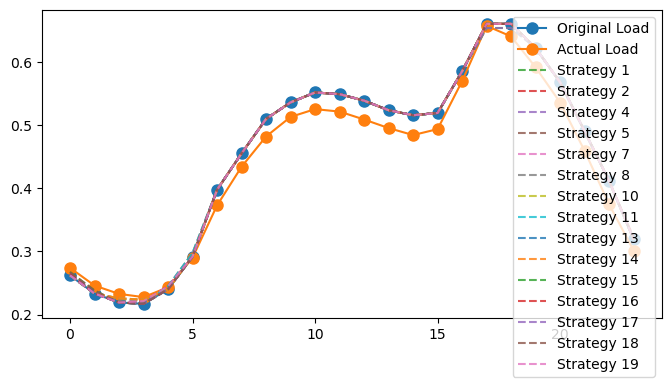

Found 0 relevant failed reflection cases for inquiry 0


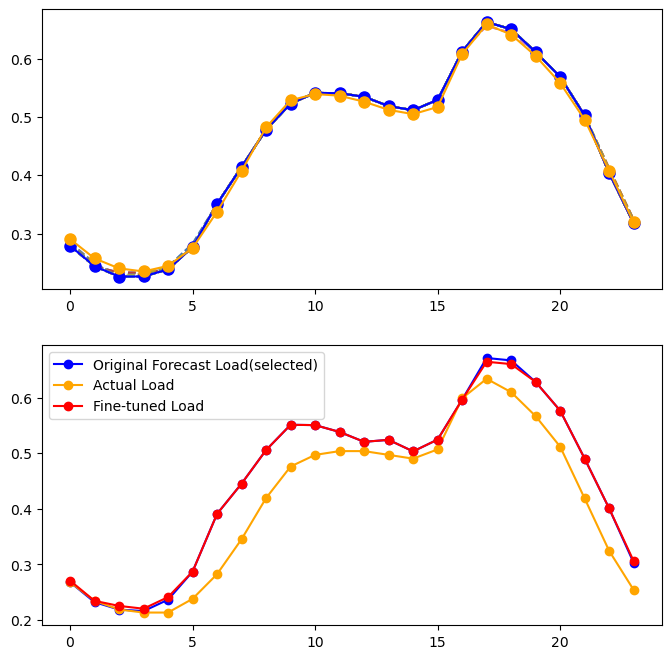

Original cost: 2578.9034243164065, Fine-tuned cost: 2579.0135881578685
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2572.01, original cost 2578.90, (reduction 6.89)
Discovered valid strategy strategy_7, cost 2576.70, original cost 2578.90, (reduction 2.20)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2572.01, original cost 2578.90, (reduction 6.89)
Discovered valid strategy strategy_6, cost 2576.70, original cost 2578.90, (reduction 2.20)
Discovered valid strategy strategy_9, cost 2575.25, original cost 2578.90, (reduction 3.65)
The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 2/29
Found 3 similar days for inquiry 1
Generating few-sho

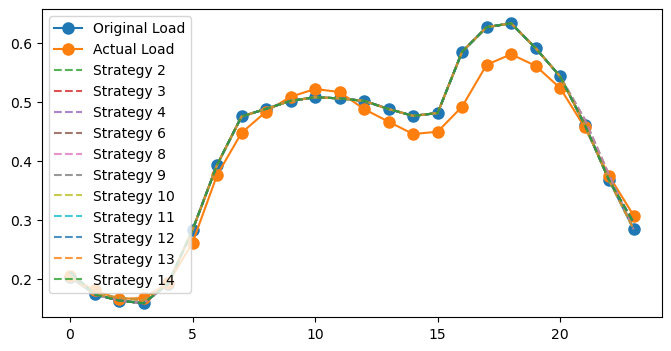

Found 1 relevant failed reflection cases for inquiry 1


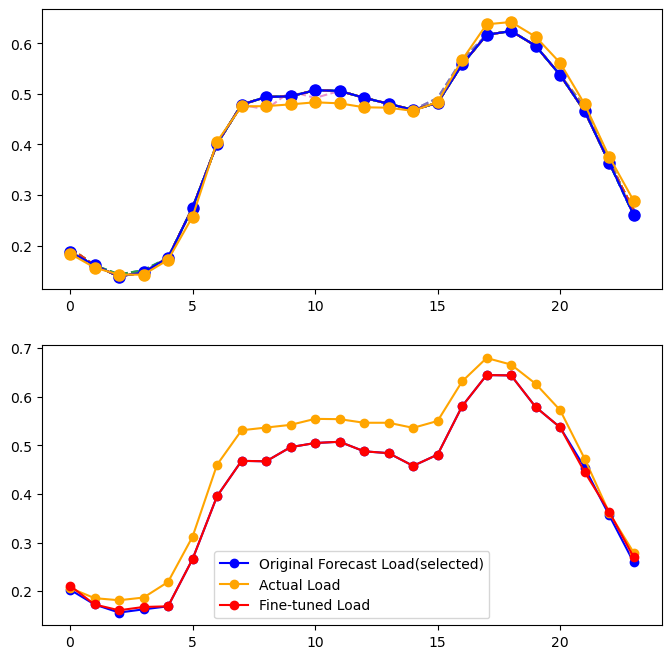

Original cost: 3131.265495117187, Fine-tuned cost: 3119.1464138273477
2855.084459716797
2849.080000992608


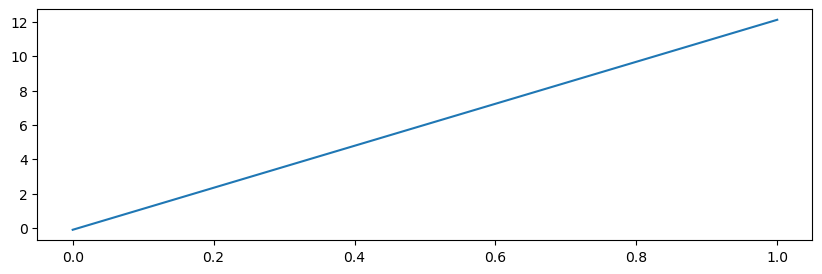

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 3/29
Found 3 similar days for inquiry 2
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2487.39, original cost 2494.44, (reduction 7.05)
Discovered valid strategy strategy_8, cost 2493.37, original cost 2494.44, (reduction 1.07)
Discovered valid strategy strategy_9, cost 2493.02, original cost 2494.44, (reduction 1.42)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_3, cost 2487.39, original cost 2494.44, (reduction 7.05)
Discovered valid strategy strategy_6, cost 2493.37, original cost 2494.44, (reduction 1.07)
Discovered valid strategy strategy_7, cost 2493.02, original co

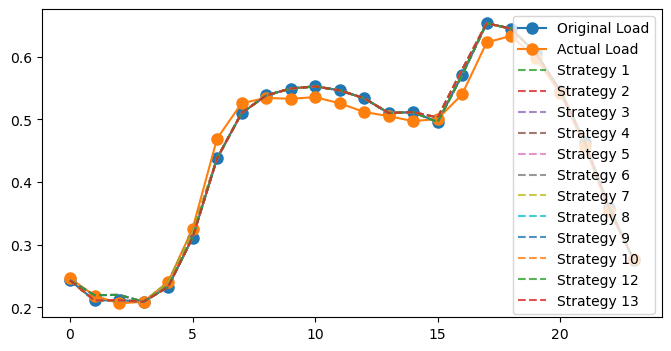

Found 1 relevant failed reflection cases for inquiry 2


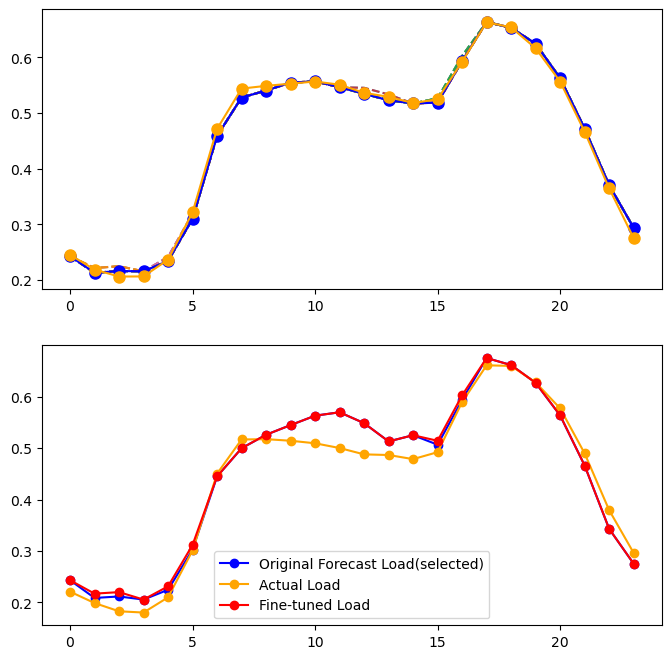

Original cost: 2574.699654296875, Fine-tuned cost: 2587.5604743073077
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_8, cost 2552.63, original cost 2574.70, (reduction 22.07)
Discovered valid strategy strategy_9, cost 2573.58, original cost 2574.70, (reduction 1.12)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_7, cost 2557.05, original cost 2574.70, (reduction 17.65)
Discovered valid strategy strategy_9, cost 2572.47, original cost 2574.70, (reduction 2.23)
Strategy generation attempt #3 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_6, cost 2571.75, original cost 2574.70, (reduction 2.95)
2761.6228579101567
2761.906825430841


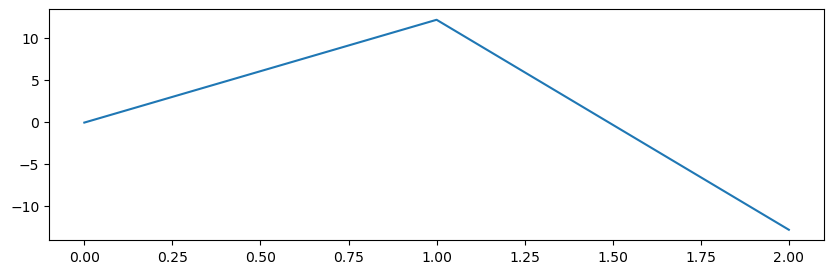

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 4/29
Found 3 similar days for inquiry 3
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2504.28, original cost 2506.02, (reduction 1.74)
Discovered valid strategy strategy_5, cost 2502.75, original cost 2506.02, (reduction 3.28)
Discovered valid strategy strategy_8, cost 2503.25, original cost 2506.02, (reduction 2.78)
Discovered valid strategy strategy_10, cost 2496.19, original cost 2506.02, (reduction 9.84)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_1, cost 2504.28, original cost 2506.02, (reduction 1.74)
Discovered valid strategy strategy_3, cost 2503.25, original c

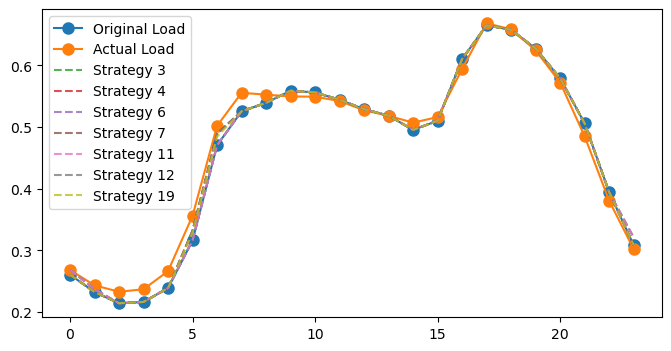

Found 1 relevant failed reflection cases for inquiry 3


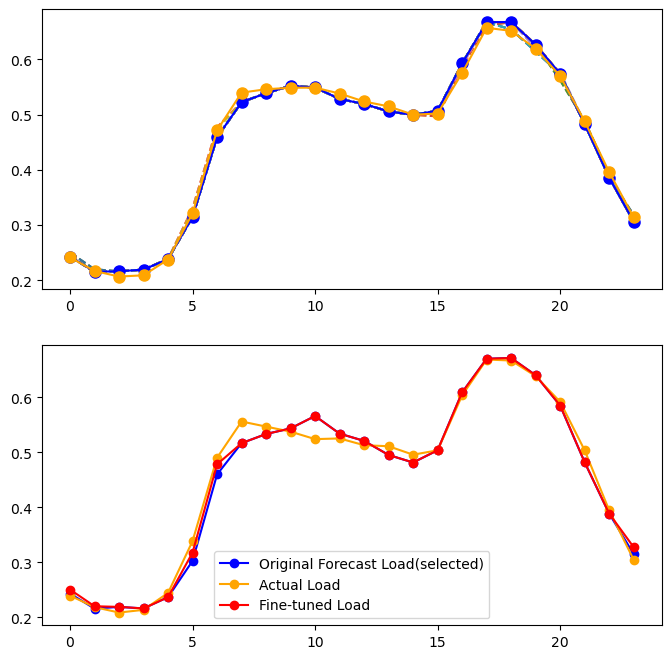

Original cost: 2594.252040527344, Fine-tuned cost: 2574.094104433632
2719.7801535644535
2714.953645181539


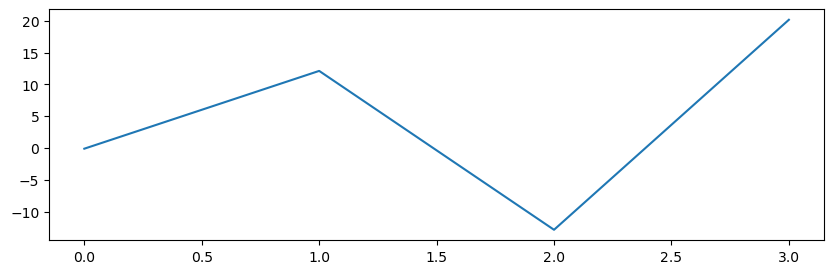

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 5/29
Found 3 similar days for inquiry 4
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2763.06, original cost 2777.87, (reduction 14.81)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_7, cost 2763.60, original cost 2777.87, (reduction 14.27)
Discovered valid strategy strategy_10, cost 2772.18, original cost 2777.87, (reduction 5.69)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
执行策略代码块失败: invalid syntax (<string>, line 47)
No valid strategy functions generated
Strategy generation attempt #4 (Current valid strategies: 3/20)
Pro

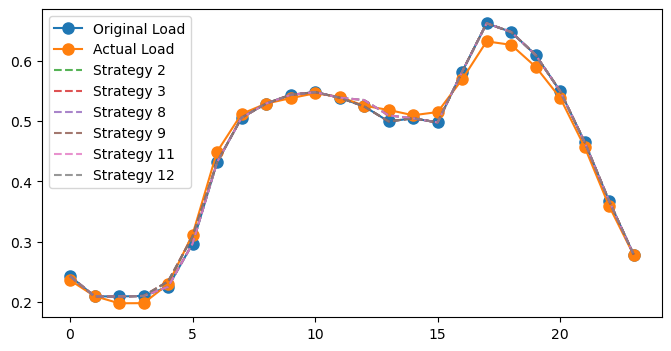

Found 1 relevant failed reflection cases for inquiry 4


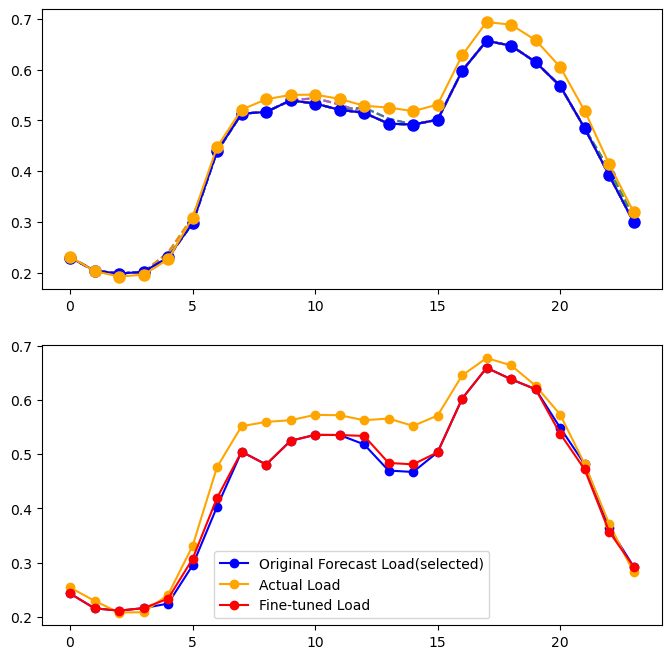

Original cost: 3034.287154296874, Fine-tuned cost: 2996.9263036734756
2782.6815537109374
2771.348176879926


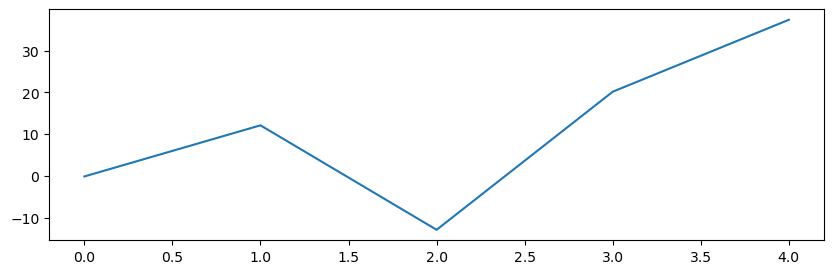

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 6/29
Found 3 similar days for inquiry 5
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_6, cost 2440.37, original cost 2445.32, (reduction 4.95)
Discovered valid strategy strategy_10, cost 2443.82, original cost 2445.32, (reduction 1.49)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_6, cost 2440.37, original cost 2445.32, (reduction 4.95)
Discovered valid strategy strategy_7, cost 2443.82, original cost 2445.32, (reduction 1.49)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_1, cost 2437.07, original 

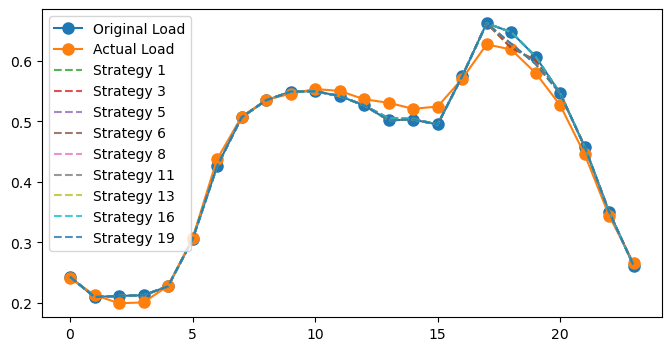

Found 1 relevant failed reflection cases for inquiry 5


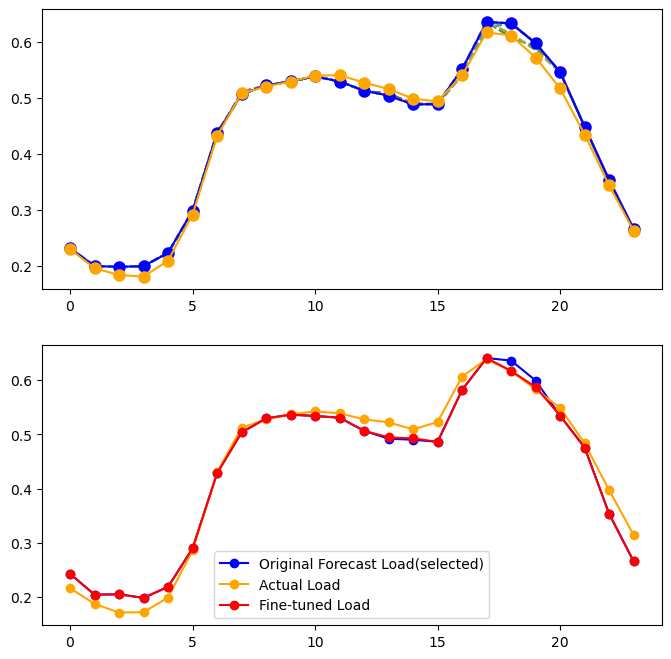

Original cost: 2620.90227734375, Fine-tuned cost: 2609.1593795069925
2755.7183409830727
2744.316710651104


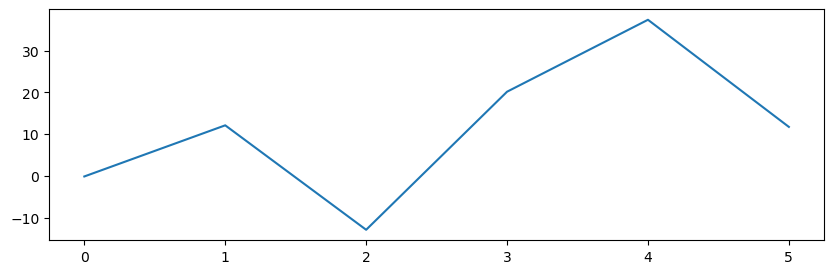

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 7/29
Found 3 similar days for inquiry 6
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_4, cost 2442.63, original cost 2446.71, (reduction 4.07)
Discovered valid strategy strategy_9, cost 2441.46, original cost 2446.71, (reduction 5.25)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_4, cost 2442.63, original cost 2446.71, (reduction 4.07)
Discovered valid strategy strategy_6, cost 2441.46, original cost 2446.71, (reduction 5.25)
Discovered valid strategy strategy_8, cost 2444.12, original cost 2446.71, (reduction 2.59)
Strategy generation attempt #3 (Current valid strategies: 5/20)

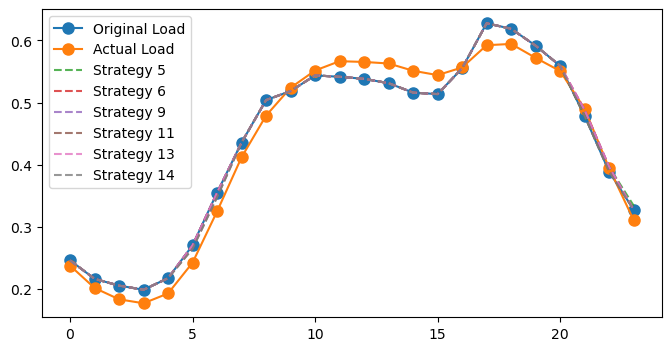

Found 1 relevant failed reflection cases for inquiry 6


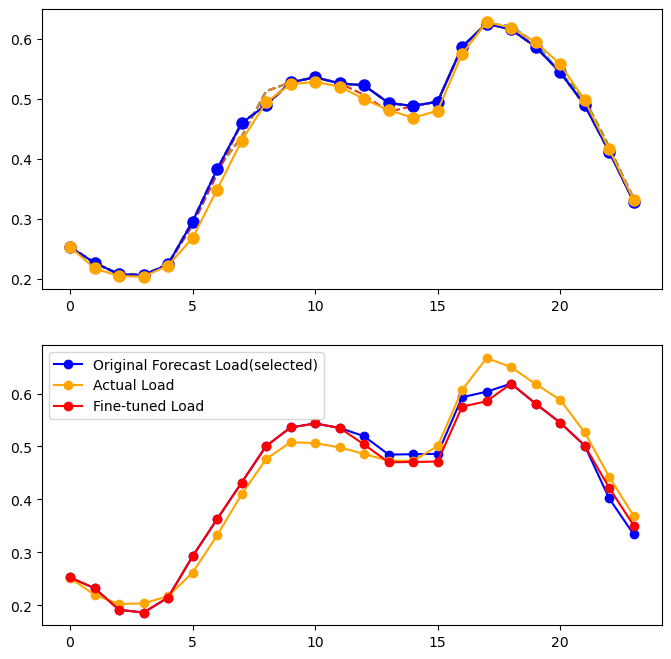

Original cost: 2683.4193647460934, Fine-tuned cost: 2685.998750358718
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2677.15, original cost 2683.42, (reduction 6.27)
Discovered valid strategy strategy_3, cost 2680.36, original cost 2683.42, (reduction 3.06)
Discovered valid strategy strategy_7, cost 2676.33, original cost 2683.42, (reduction 7.09)
Discovered valid strategy strategy_8, cost 2667.70, original cost 2683.42, (reduction 15.72)
Discovered valid strategy strategy_9, cost 2680.75, original cost 2683.42, (reduction 2.67)
2745.3899158063614
2735.9855734664775


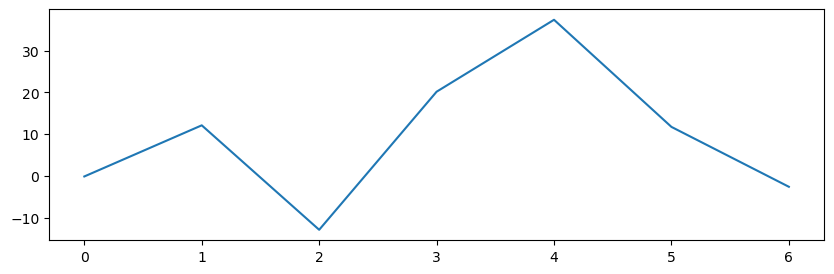

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 8/29
Found 3 similar days for inquiry 7
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2547.72, original cost 2556.35, (reduction 8.63)
Discovered valid strategy strategy_8, cost 2555.28, original cost 2556.35, (reduction 1.07)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_3, cost 2547.72, original cost 2556.35, (reduction 8.63)
Discovered valid strategy strategy_6, cost 2555.28, original cost 2556.35, (reduction 1.07)
Discovered valid strategy strategy_7, cost 2553.45, original cost 2556.35, (reduction 2.91)
Discovered valid strategy strategy_9, cost 2551.13, original co

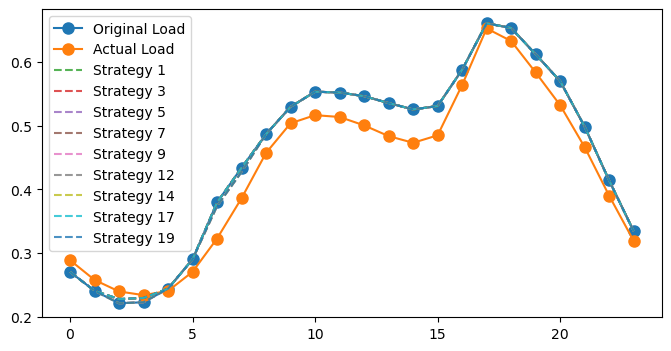

Found 1 relevant failed reflection cases for inquiry 7


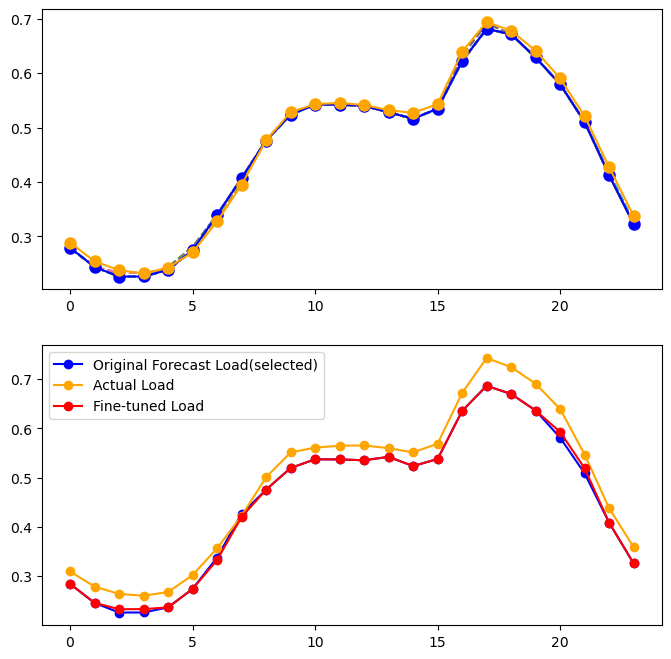

Original cost: 3052.8220673828123, Fine-tuned cost: 3031.885232742101
2783.8189347534176
2772.9730308759304


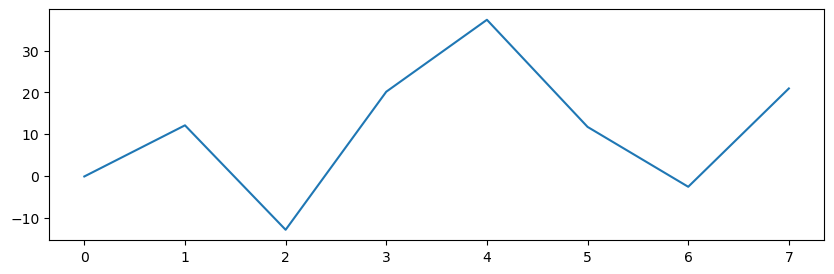

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 9/29
Found 3 similar days for inquiry 8
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2741.54, original cost 2761.18, (reduction 19.64)
Discovered valid strategy strategy_7, cost 2744.92, original cost 2761.18, (reduction 16.27)
Discovered valid strategy strategy_10, cost 2736.10, original cost 2761.18, (reduction 25.08)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_3, cost 2741.54, original cost 2761.18, (reduction 19.64)
Discovered valid strategy strategy_6, cost 2744.92, original cost 2761.18, (reduction 16.27)
Discovered valid strategy strategy_7, cost 2736.10, origi

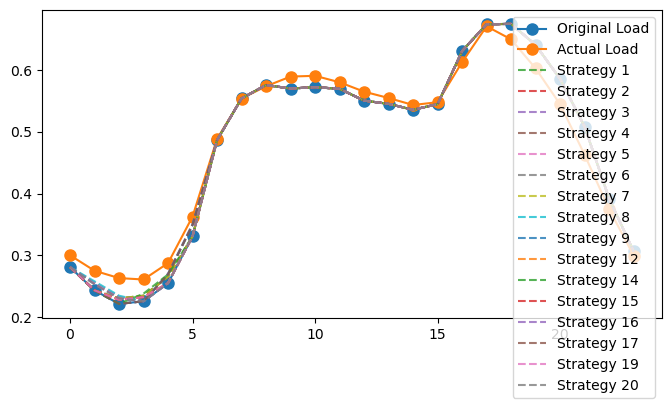

Found 1 relevant failed reflection cases for inquiry 8


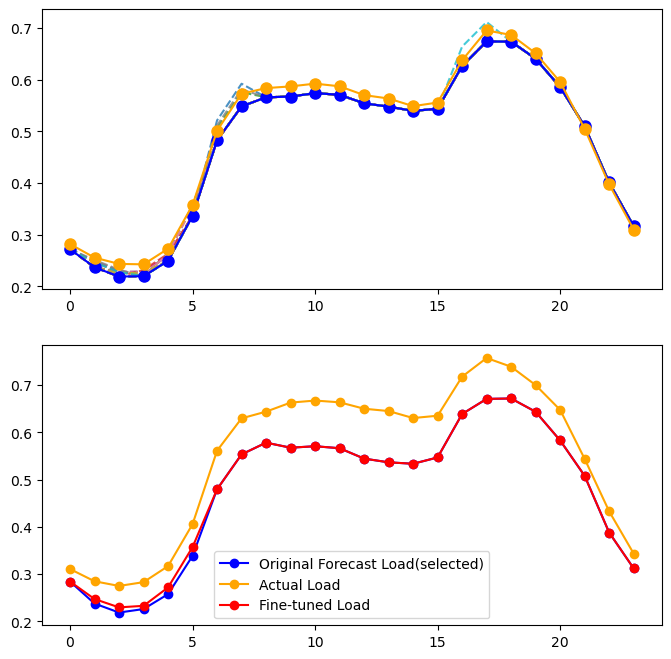

Original cost: 3842.1014096679683, Fine-tuned cost: 3799.219565143555
2901.40587641059
2887.000423572333


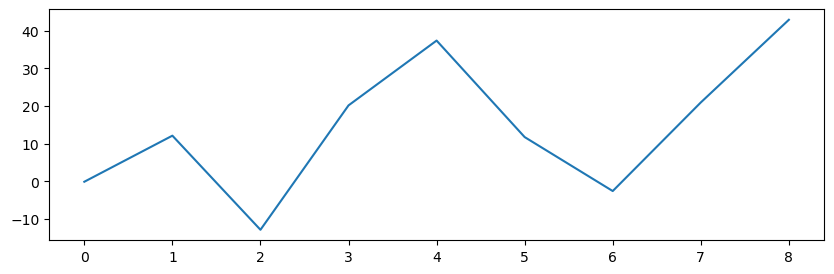

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 10/29
Found 3 similar days for inquiry 9
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2746.45, original cost 2761.18, (reduction 14.73)
Discovered valid strategy strategy_6, cost 2738.49, original cost 2761.18, (reduction 22.69)
Discovered valid strategy strategy_9, cost 2758.94, original cost 2761.18, (reduction 2.24)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_3, cost 2746.45, original cost 2761.18, (reduction 14.73)
Discovered valid strategy strategy_6, cost 2738.49, original cost 2761.18, (reduction 22.69)
Discovered valid strategy strategy_7, cost 2758.94, origin

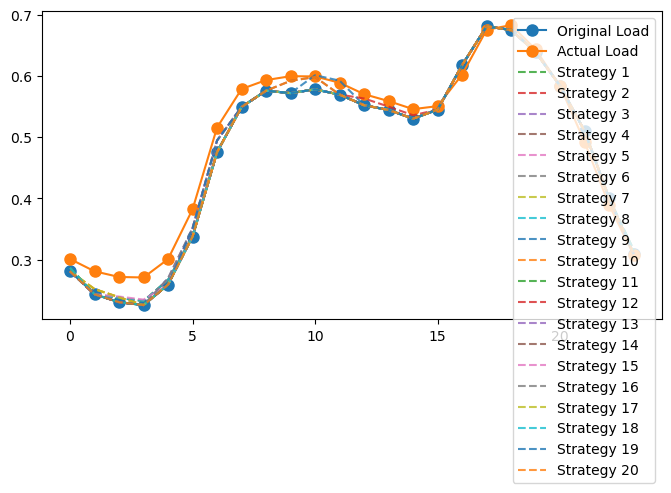

Found 1 relevant failed reflection cases for inquiry 9


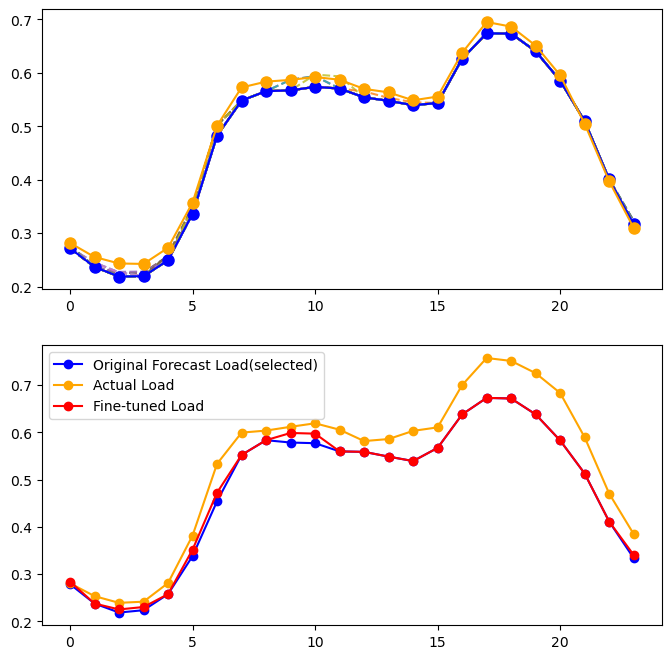

Original cost: 3418.686769042969, Fine-tuned cost: 3353.00499606618
2953.133965673828
2933.600880821718


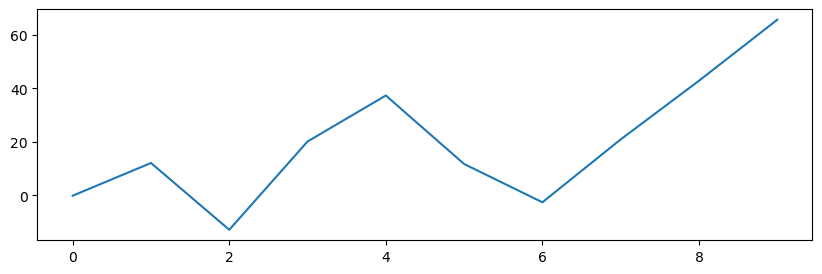

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 11/29
Found 3 similar days for inquiry 10
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2946.52, original cost 2961.55, (reduction 15.03)
Discovered valid strategy strategy_7, cost 2957.63, original cost 2961.55, (reduction 3.91)
Discovered valid strategy strategy_8, cost 2942.43, original cost 2961.55, (reduction 19.12)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 2957.63, original cost 2961.55, (reduction 3.91)
Discovered valid strategy strategy_3, cost 2950.97, original cost 2961.55, (reduction 10.58)
Discovered valid strategy strategy_6, cost 2942.80, origin

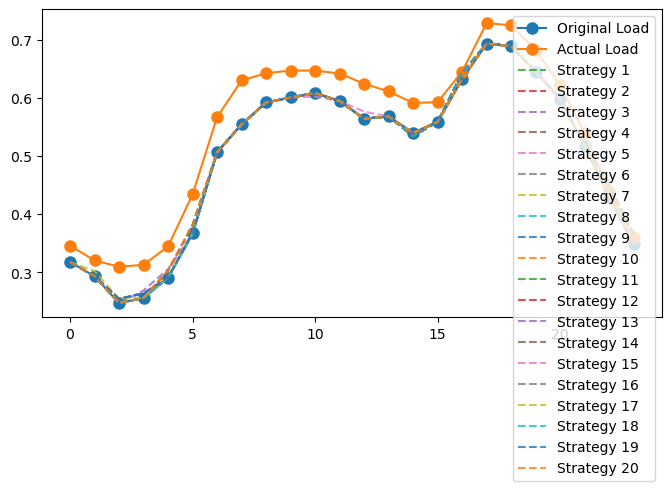

Found 1 relevant failed reflection cases for inquiry 10


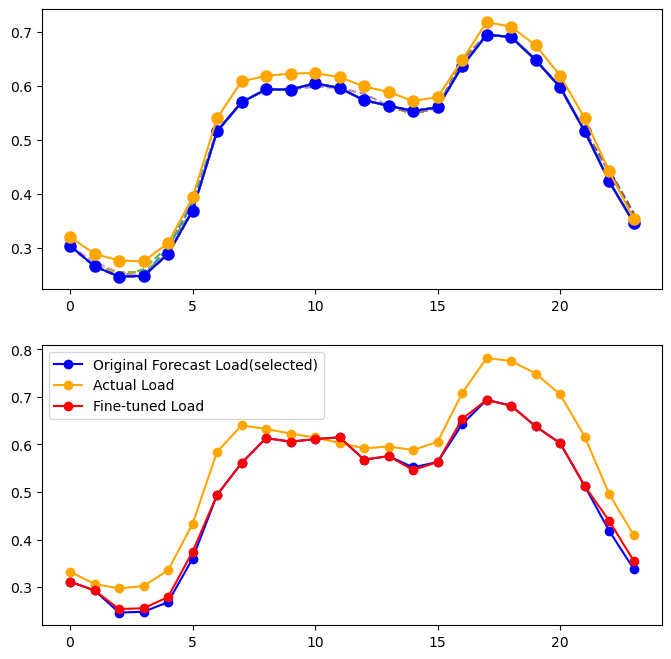

Original cost: 3604.679898925782, Fine-tuned cost: 3545.340865890354
3012.3654141512784
2989.213606737049


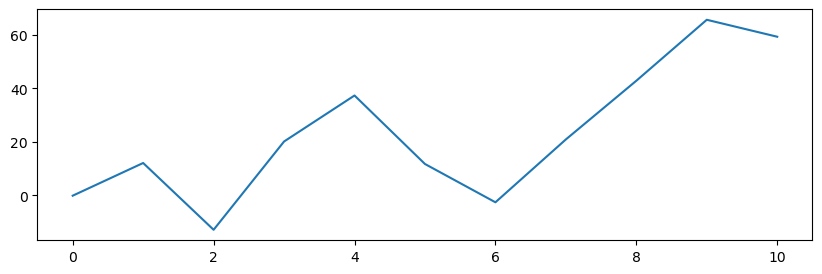

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 12/29
Found 3 similar days for inquiry 11
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 3048.66, original cost 3064.55, (reduction 15.89)
Discovered valid strategy strategy_8, cost 3039.52, original cost 3064.55, (reduction 25.04)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_2, cost 3056.62, original cost 3064.55, (reduction 7.94)
Discovered valid strategy strategy_3, cost 3048.66, original cost 3064.55, (reduction 15.89)
Discovered valid strategy strategy_6, cost 3039.52, original cost 3064.55, (reduction 25.04)
Discovered valid strategy strategy_7, cost 3038.37, origi

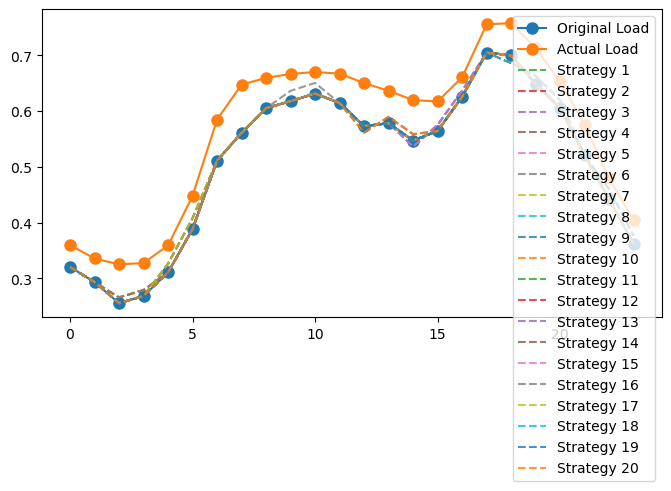

Found 1 relevant failed reflection cases for inquiry 11


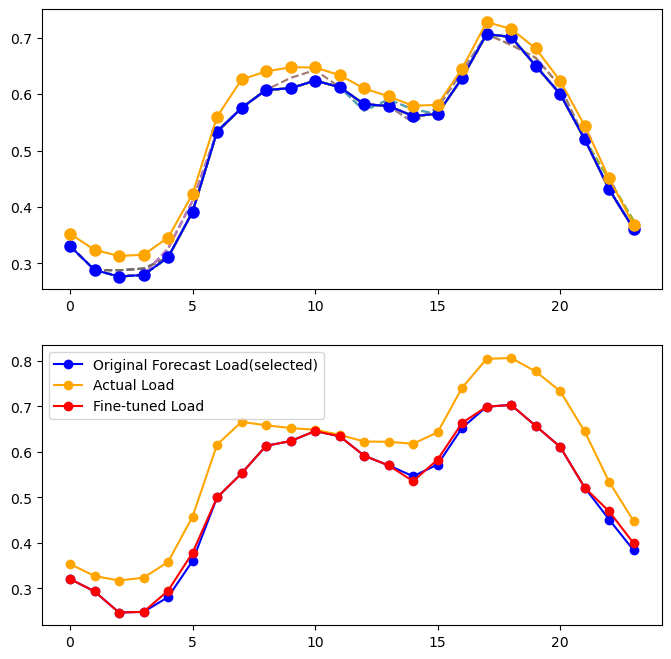

Original cost: 3959.599854980468, Fine-tuned cost: 3905.2869396090923
3091.301617553711
3065.553051143052


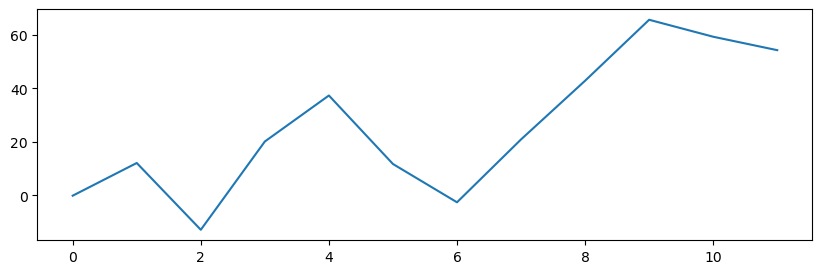

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 13/29
Found 3 similar days for inquiry 12
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 3052.64, original cost 3064.55, (reduction 11.92)
Discovered valid strategy strategy_7, cost 3048.13, original cost 3064.55, (reduction 16.42)
Discovered valid strategy strategy_10, cost 3044.51, original cost 3064.55, (reduction 20.05)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 3046.91, original cost 3064.55, (reduction 17.65)
Discovered valid strategy strategy_3, cost 3052.64, original cost 3064.55, (reduction 11.92)
Discovered valid strategy strategy_6, cost 3048.13, ori

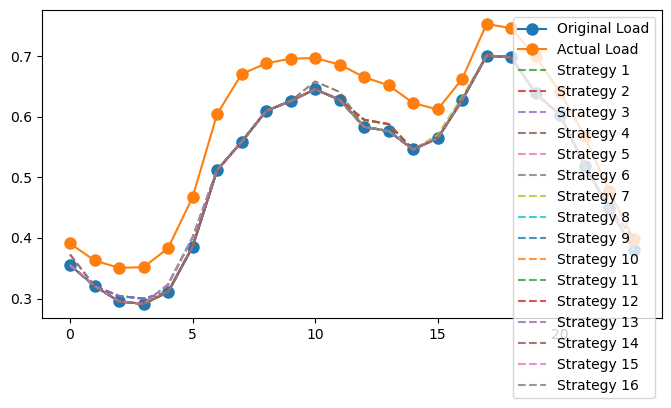

Found 1 relevant failed reflection cases for inquiry 12


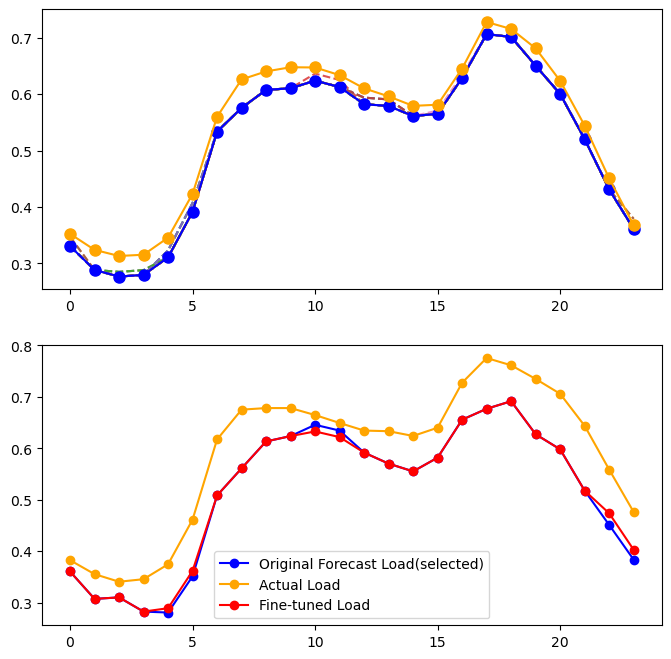

Original cost: 3991.7390185546874, Fine-tuned cost: 3966.6835621532346
3160.566033015325
3134.87078275922


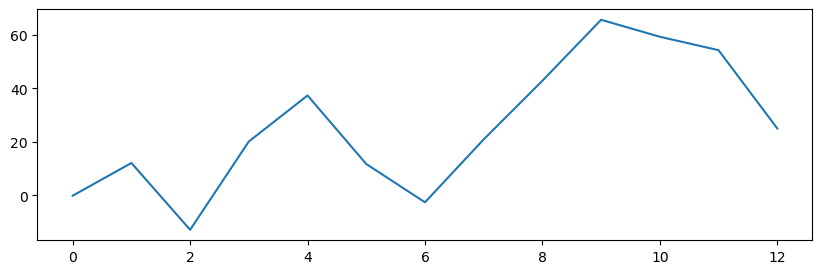

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 14/29
Found 3 similar days for inquiry 13
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2787.25, original cost 2799.97, (reduction 12.72)
Discovered valid strategy strategy_7, cost 2790.33, original cost 2799.97, (reduction 9.65)
Discovered valid strategy strategy_9, cost 2788.69, original cost 2799.97, (reduction 11.28)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_3, cost 2787.25, original cost 2799.97, (reduction 12.72)
Discovered valid strategy strategy_6, cost 2790.33, original cost 2799.97, (reduction 9.65)
Discovered valid strategy strategy_7, cost 2788.69, origin

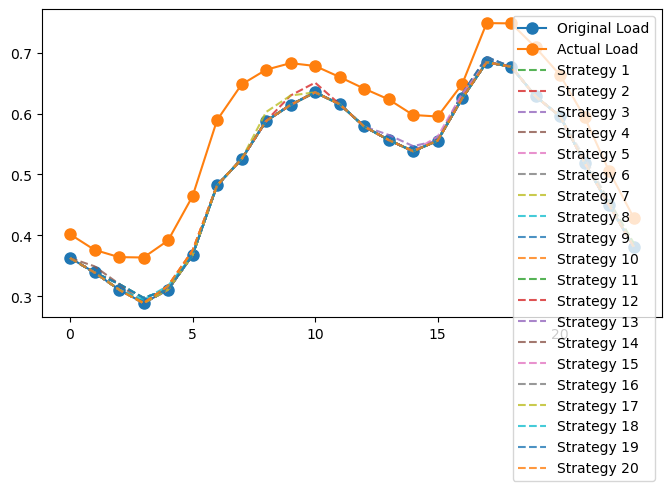

Found 1 relevant failed reflection cases for inquiry 13


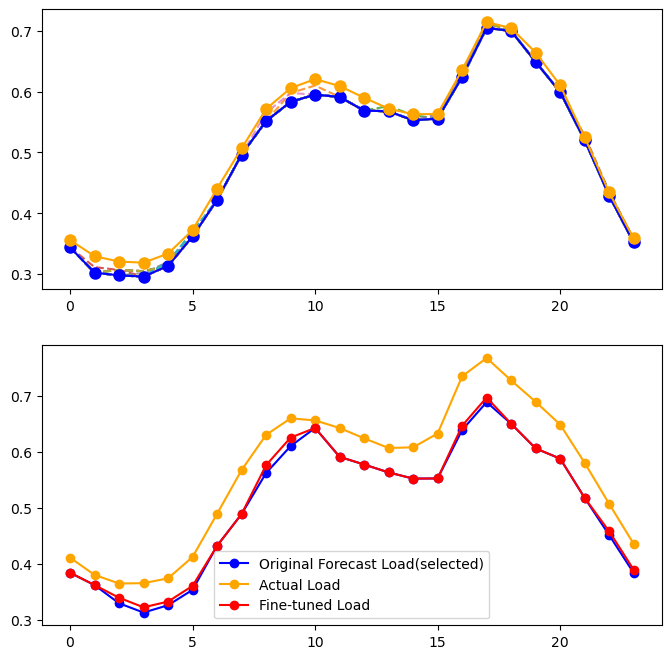

Original cost: 3637.495817382812, Fine-tuned cost: 3573.1615890134412
3194.632446184431
3166.177268920236


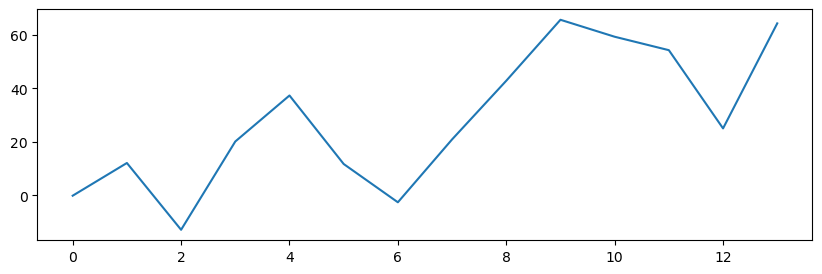

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 15/29
Found 3 similar days for inquiry 14
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2742.56, original cost 2763.33, (reduction 20.77)
Discovered valid strategy strategy_7, cost 2741.28, original cost 2763.33, (reduction 22.05)
Discovered valid strategy strategy_10, cost 2743.39, original cost 2763.33, (reduction 19.94)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_3, cost 2742.56, original cost 2763.33, (reduction 20.77)
Discovered valid strategy strategy_6, cost 2741.28, original cost 2763.33, (reduction 22.05)
Discovered valid strategy strategy_8, cost 2743.39, ori

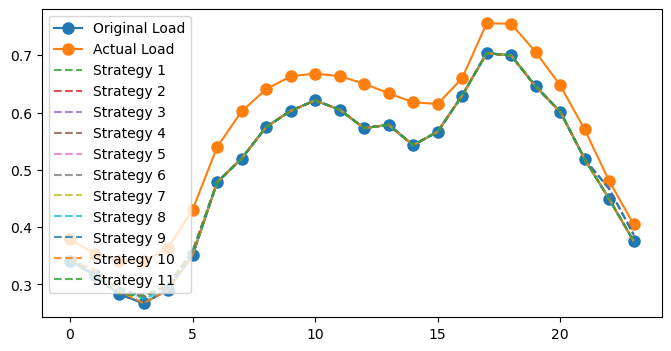

Found 1 relevant failed reflection cases for inquiry 14


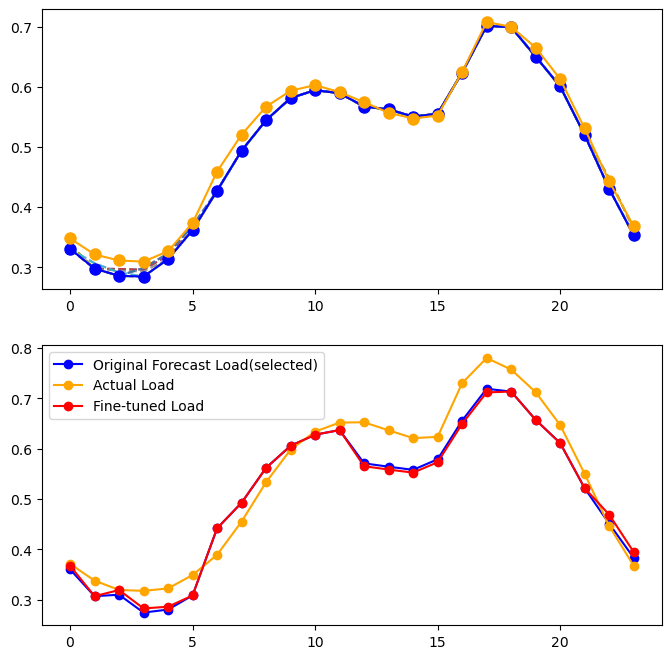

Original cost: 3183.558201171875, Fine-tuned cost: 3195.4653189282476
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_3, cost 3175.15, original cost 3183.56, (reduction 8.41)
Discovered valid strategy strategy_7, cost 3177.66, original cost 3183.56, (reduction 5.90)
Discovered valid strategy strategy_8, cost 3176.95, original cost 3183.56, (reduction 6.61)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_3, cost 3175.15, original cost 3183.56, (reduction 8.41)
Discovered valid strategy strategy_6, cost 3181.98, original cost 3183.56, (reduction 1.58)
3193.8941631835937
3168.1298055874367


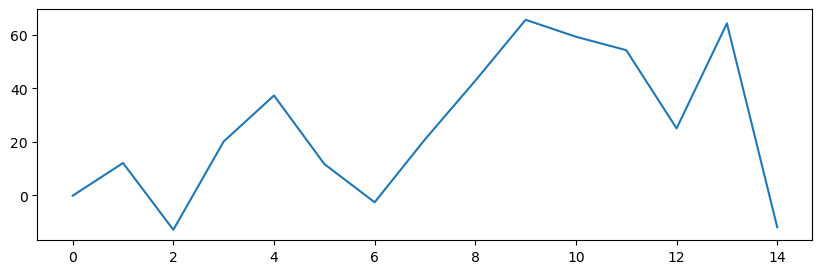

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 16/29
Found 3 similar days for inquiry 15
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2848.13, original cost 2856.00, (reduction 7.87)
Discovered valid strategy strategy_3, cost 2833.71, original cost 2856.00, (reduction 22.29)
Discovered valid strategy strategy_5, cost 2847.57, original cost 2856.00, (reduction 8.42)
Discovered valid strategy strategy_7, cost 2847.47, original cost 2856.00, (reduction 8.53)
Discovered valid strategy strategy_8, cost 2842.65, original cost 2856.00, (reduction 13.35)
Strategy generation attempt #2 (Current valid strategies: 5/20)
Discovered valid strategy strategy_2, cost 2848.13, origina

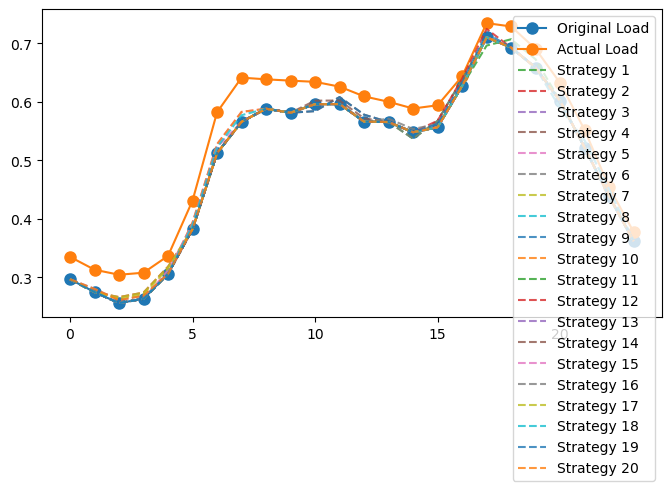

Found 1 relevant failed reflection cases for inquiry 15


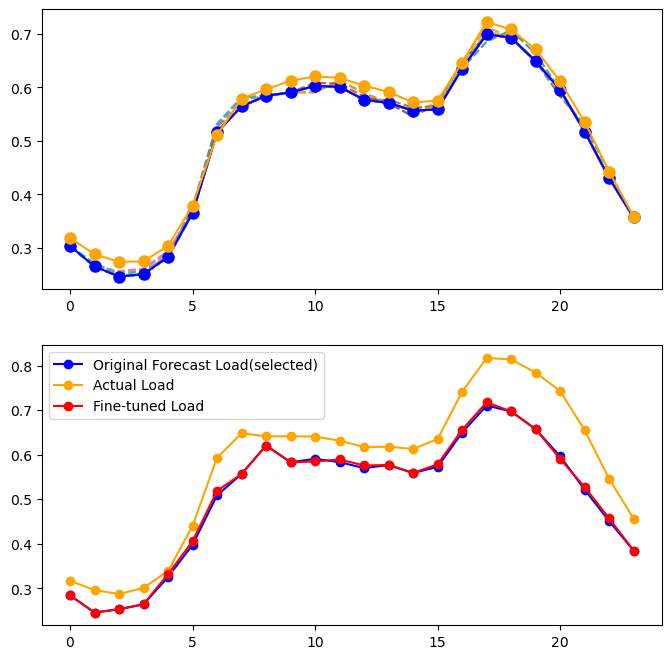

Original cost: 3885.3123837890626, Fine-tuned cost: 3845.7124399340382
3237.107801971435
3210.4787202340995


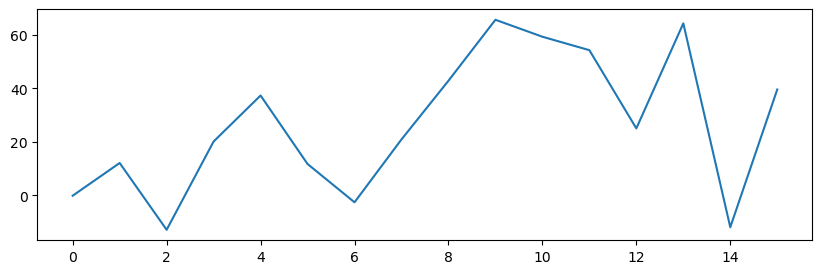

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 17/29
Found 3 similar days for inquiry 16
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 3052.20, original cost 3064.55, (reduction 12.35)
Discovered valid strategy strategy_3, cost 3052.64, original cost 3064.55, (reduction 11.92)
Discovered valid strategy strategy_7, cost 3052.43, original cost 3064.55, (reduction 12.13)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_2, cost 3052.20, original cost 3064.55, (reduction 12.35)
Discovered valid strategy strategy_3, cost 3052.64, original cost 3064.55, (reduction 11.92)
Discovered valid strategy strategy_6, cost 3052.43, orig

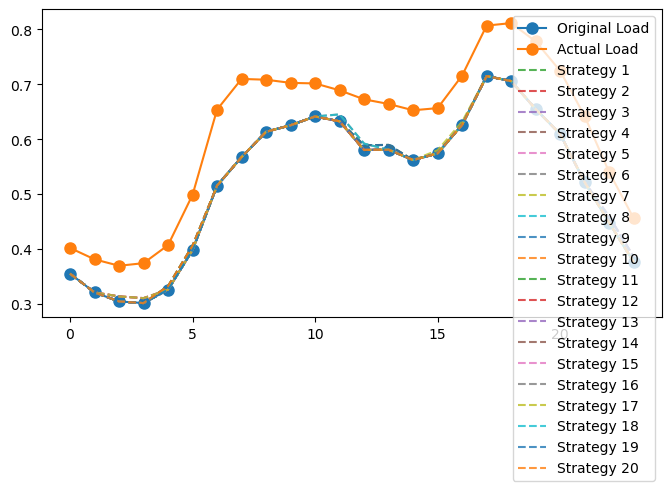

Found 1 relevant failed reflection cases for inquiry 16


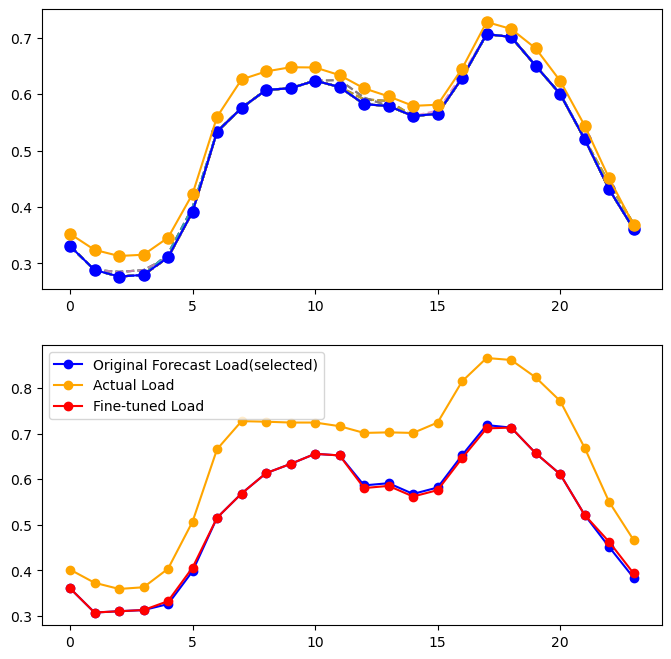

Original cost: 4750.938308105468, Fine-tuned cost: 4751.951668711828
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_3, cost 4740.32, original cost 4750.94, (reduction 10.62)
Discovered valid strategy strategy_6, cost 4737.60, original cost 4750.94, (reduction 13.34)
Discovered valid strategy strategy_9, cost 4746.53, original cost 4750.94, (reduction 4.41)
Strategy generation attempt #2 (Current valid strategies: 3/5)
Providing actual load values
Discovered valid strategy strategy_2, cost 4746.30, original cost 4750.94, (reduction 4.64)
Discovered valid strategy strategy_3, cost 4740.32, original cost 4750.94, (reduction 10.62)
3326.156655273437
3301.153599556319


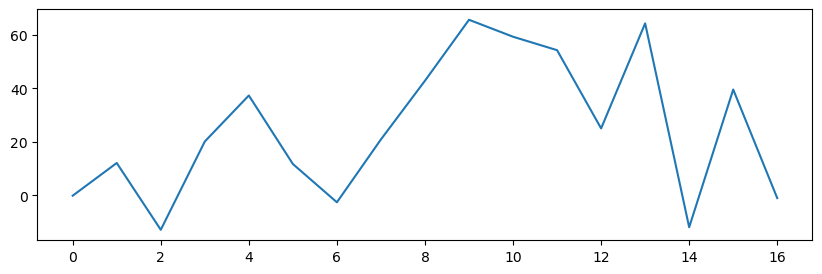

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 18/29
Found 3 similar days for inquiry 17
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 3060.59, original cost 3064.55, (reduction 3.97)
Discovered valid strategy strategy_3, cost 3039.79, original cost 3064.55, (reduction 24.76)
Discovered valid strategy strategy_8, cost 3052.01, original cost 3064.55, (reduction 12.54)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_3, cost 3052.64, original cost 3064.55, (reduction 11.92)
Discovered valid strategy strategy_6, cost 3049.26, original cost 3064.55, (reduction 15.30)
Discovered valid strategy strategy_8, cost 3051.29, origi

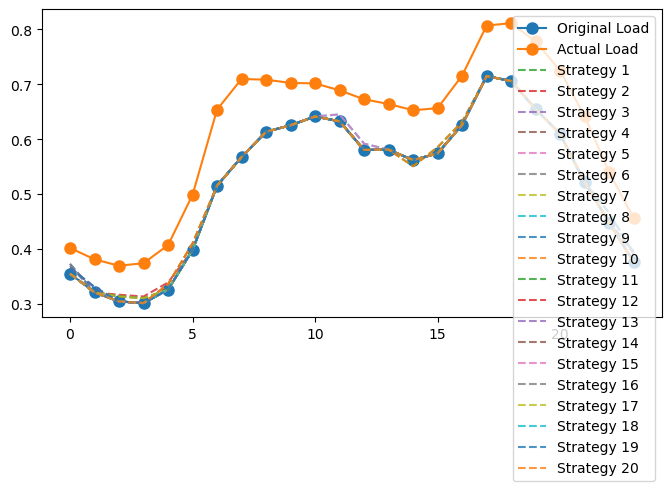

Found 1 relevant failed reflection cases for inquiry 17


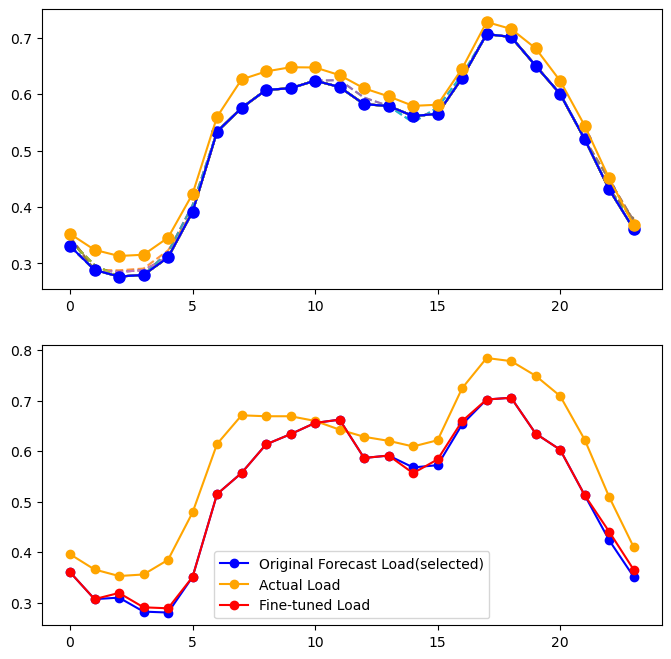

Original cost: 3882.43232421875, Fine-tuned cost: 3837.0282043086527
3357.0608591037326
3330.9244109314486


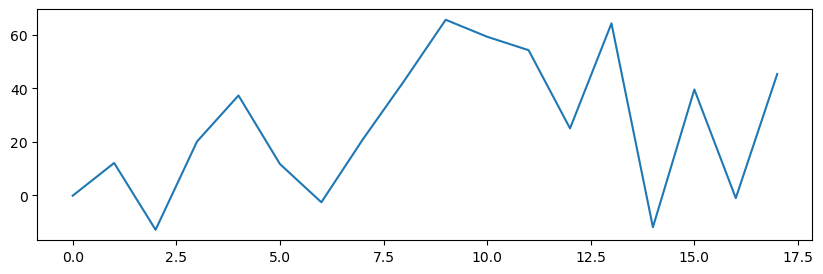

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 19/29
Found 3 similar days for inquiry 18
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2940.51, original cost 2954.15, (reduction 13.63)
Discovered valid strategy strategy_8, cost 2938.11, original cost 2954.15, (reduction 16.04)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_3, cost 2940.51, original cost 2954.15, (reduction 13.63)
Discovered valid strategy strategy_6, cost 2938.11, original cost 2954.15, (reduction 16.04)
Discovered valid strategy strategy_9, cost 2922.05, original cost 2954.15, (reduction 32.10)
Strategy generation attempt #3 (Current valid strategies

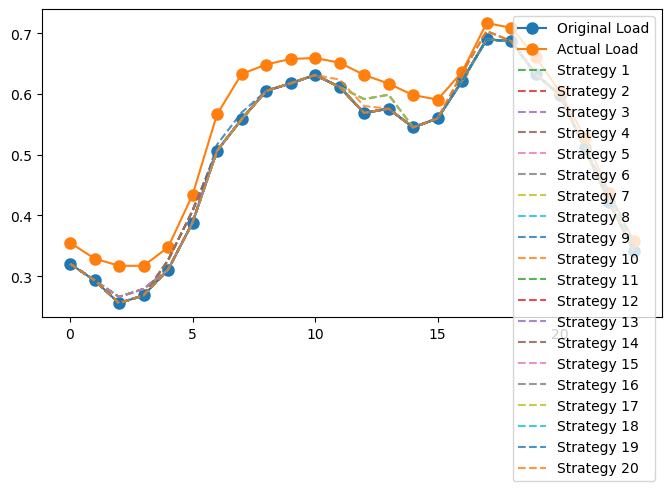

Found 1 relevant failed reflection cases for inquiry 18


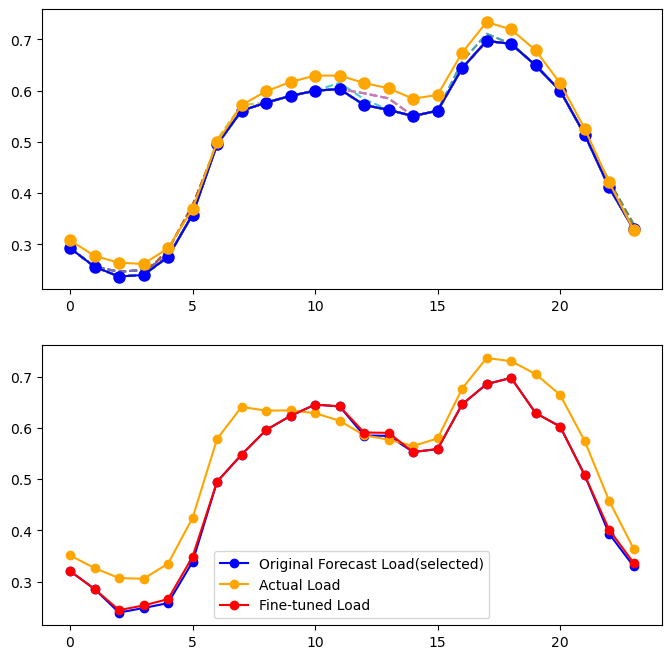

Original cost: 3376.7036972656247, Fine-tuned cost: 3349.321307524925
3358.0946926912006
3331.892668646895


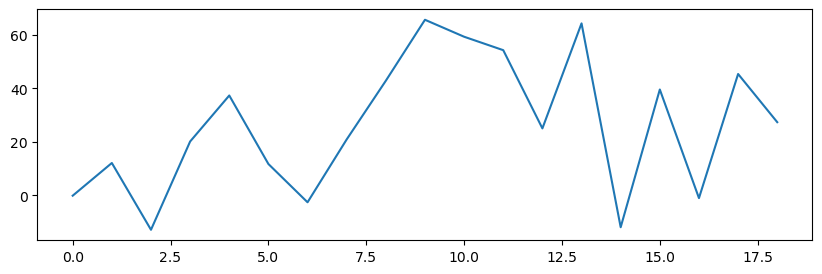

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 20/29
Found 3 similar days for inquiry 19
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2720.73, original cost 2732.98, (reduction 12.25)
Discovered valid strategy strategy_8, cost 2721.56, original cost 2732.98, (reduction 11.42)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_3, cost 2720.73, original cost 2732.98, (reduction 12.25)
Discovered valid strategy strategy_6, cost 2721.56, original cost 2732.98, (reduction 11.42)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_3, cost 2720.73, orig

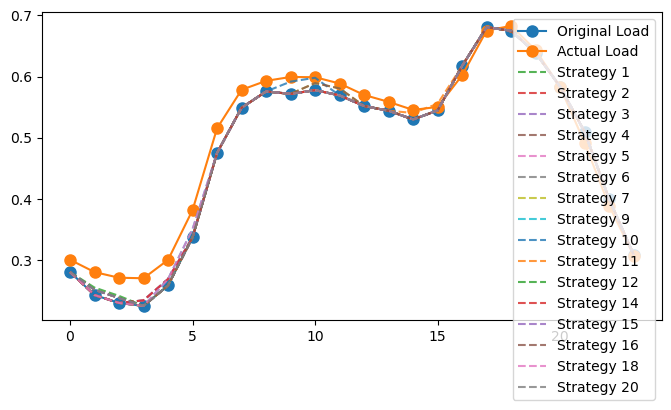

Found 1 relevant failed reflection cases for inquiry 19


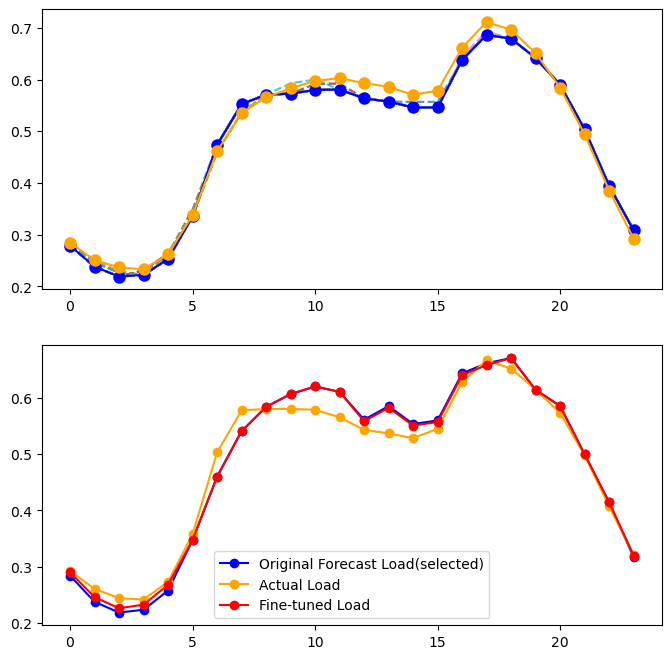

Original cost: 2690.2066416015628, Fine-tuned cost: 2657.1869870776345
3324.7002901367186
3298.1573845684316


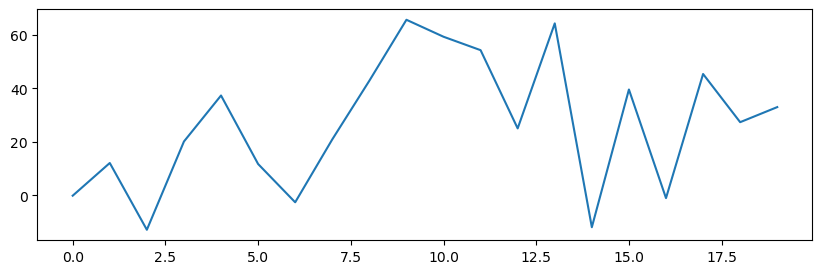

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 21/29
Found 3 similar days for inquiry 20
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2454.87, original cost 2457.35, (reduction 2.48)
Discovered valid strategy strategy_6, cost 2450.58, original cost 2457.35, (reduction 6.77)
Discovered valid strategy strategy_10, cost 2455.09, original cost 2457.35, (reduction 2.26)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2454.87, original cost 2457.35, (reduction 2.48)
Discovered valid strategy strategy_6, cost 2450.58, original cost 2457.35, (reduction 6.77)
Discovered valid strategy strategy_9, cost 2453.43, original

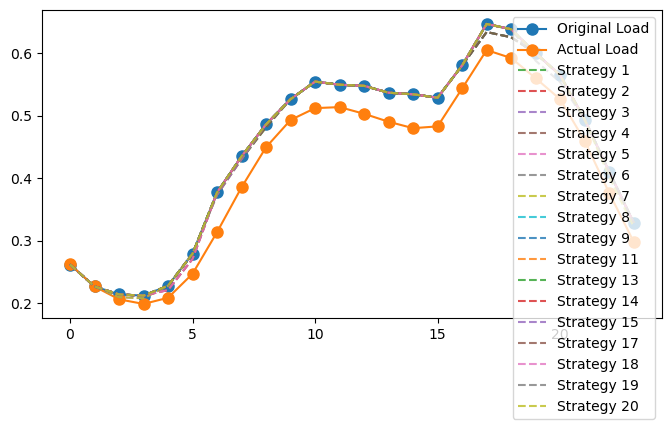

Found 1 relevant failed reflection cases for inquiry 20


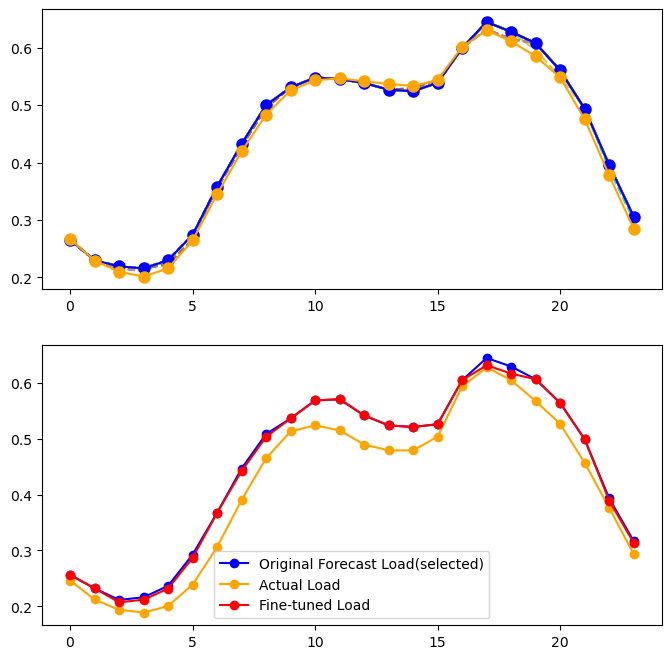

Original cost: 2538.762943359375, Fine-tuned cost: 2522.6306630853624
3287.2747021949403
3261.227540688286


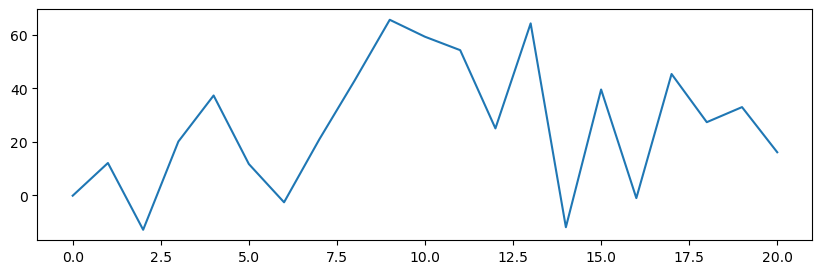

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 22/29
Found 3 similar days for inquiry 21
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_9, cost 2432.17, original cost 2433.64, (reduction 1.47)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_9, cost 2432.17, original cost 2433.64, (reduction 1.47)
Strategy generation attempt #3 (Current valid strategies: 2/20)
Providing actual load values
Discovered valid strategy strategy_8, cost 2432.03, original cost 2433.64, (reduction 1.61)
Strategy generation attempt #4 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_7, cost 2432.03, origina

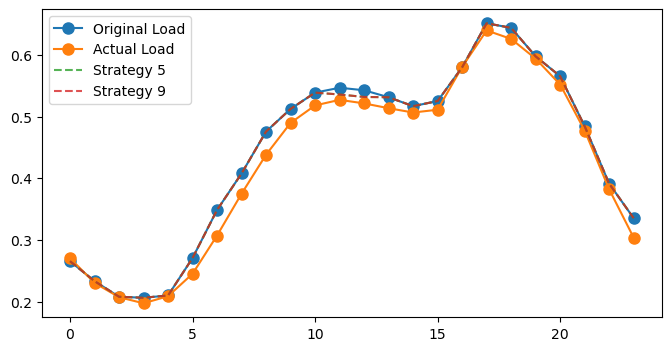

Found 1 relevant failed reflection cases for inquiry 21


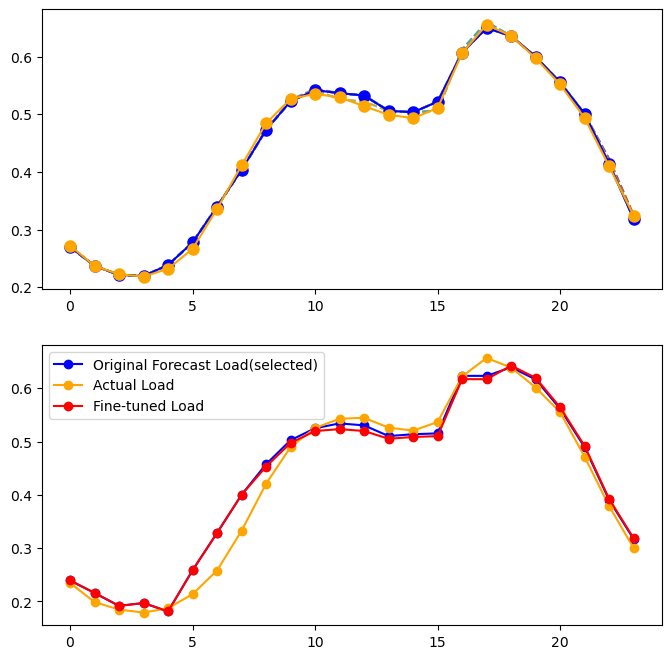

Original cost: 2502.7562250976566, Fine-tuned cost: 2541.6255505716067
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2499.37, original cost 2502.76, (reduction 3.38)
Discovered valid strategy strategy_6, cost 2499.37, original cost 2502.76, (reduction 3.38)
Strategy generation attempt #2 (Current valid strategies: 2/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2499.37, original cost 2502.76, (reduction 3.38)
Discovered valid strategy strategy_2, cost 2499.37, original cost 2502.76, (reduction 3.38)
Discovered valid strategy strategy_10, cost 2498.63, original cost 2502.76, (reduction 4.12)
3251.6147714177914
3228.518359319346


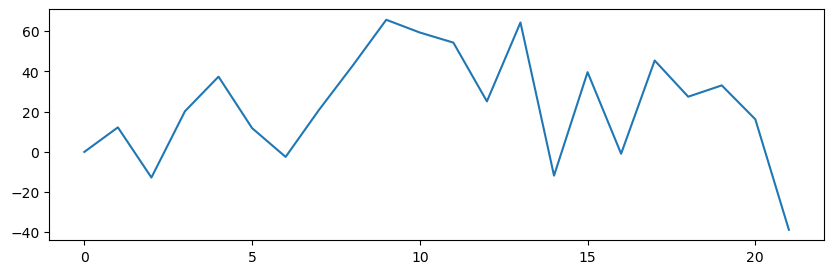

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 23/29
Found 3 similar days for inquiry 22
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2568.73, original cost 2577.24, (reduction 8.50)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_3, cost 2568.73, original cost 2577.24, (reduction 8.50)
Discovered valid strategy strategy_8, cost 2571.12, original cost 2577.24, (reduction 6.11)
Strategy generation attempt #3 (Current valid strategies: 3/20)
Providing actual load values
Discovered valid strategy strategy_3, cost 2568.73, original cost 2577.24, (reduction 8.50)
Discovered valid strategy strategy_6, cost 2571.12, original

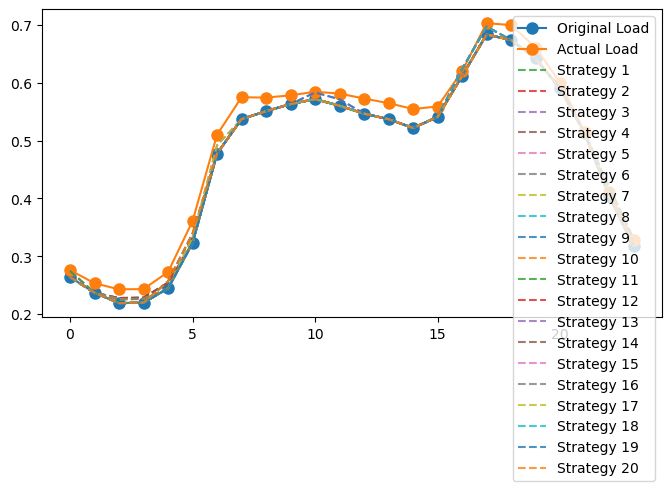

Found 1 relevant failed reflection cases for inquiry 22


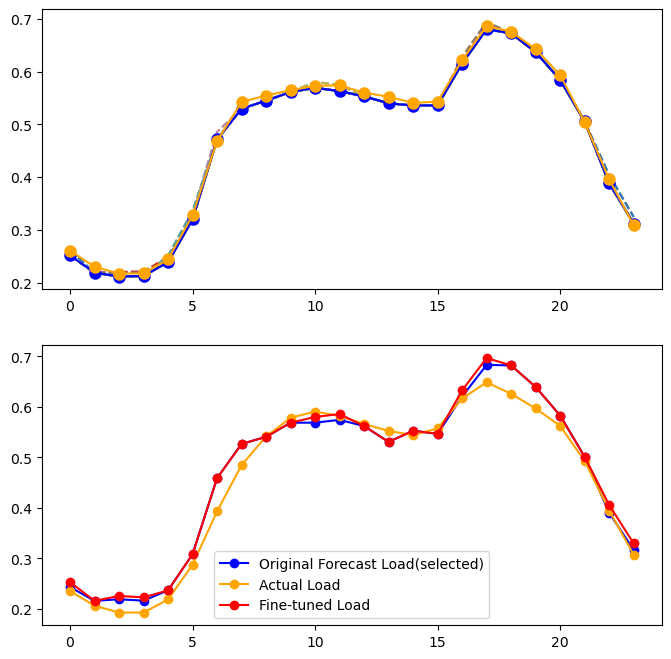

Original cost: 2585.076229492188, Fine-tuned cost: 2588.1168353930952
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2567.49, original cost 2585.08, (reduction 17.59)
Discovered valid strategy strategy_2, cost 2582.07, original cost 2585.08, (reduction 3.01)
Discovered valid strategy strategy_6, cost 2571.26, original cost 2585.08, (reduction 13.82)
Discovered valid strategy strategy_8, cost 2574.34, original cost 2585.08, (reduction 10.73)
Strategy generation attempt #2 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2567.49, original cost 2585.08, (reduction 17.59)
3222.63483481233
3200.6748148008132


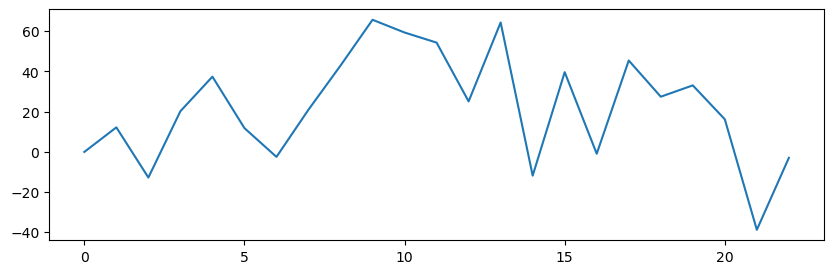

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 24/29
Found 3 similar days for inquiry 23
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_7, cost 2522.09, original cost 2523.09, (reduction 1.00)
Discovered valid strategy strategy_9, cost 2519.85, original cost 2523.09, (reduction 3.24)
Strategy generation attempt #2 (Current valid strategies: 2/20)
Discovered valid strategy strategy_1, cost 2518.81, original cost 2523.09, (reduction 4.28)
Discovered valid strategy strategy_6, cost 2516.84, original cost 2523.09, (reduction 6.25)
Discovered valid strategy strategy_7, cost 2522.09, original cost 2523.09, (reduction 1.00)
Discovered valid strategy strategy_9, cost 2519.85, original 

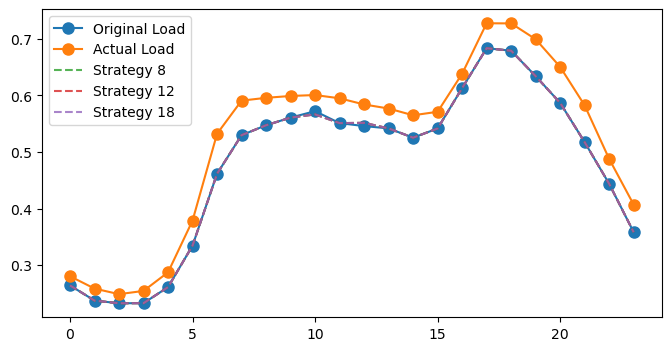

Found 1 relevant failed reflection cases for inquiry 23


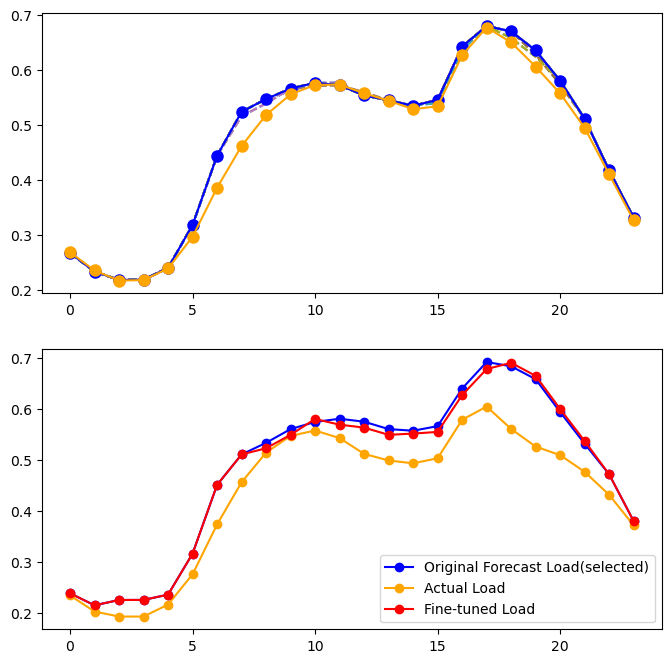

Original cost: 2678.6852836914063, Fine-tuned cost: 2660.2474777841453
3199.9702701822916
3178.157009091785


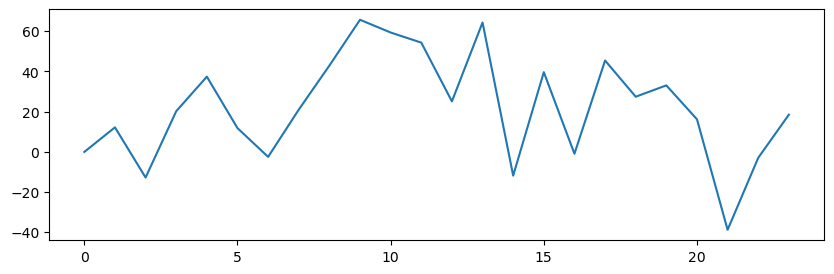

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 25/29
Found 3 similar days for inquiry 24
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2476.16, original cost 2485.45, (reduction 9.29)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_3, cost 2476.16, original cost 2485.45, (reduction 9.29)
Strategy generation attempt #3 (Current valid strategies: 2/20)
Providing actual load values
Discovered valid strategy strategy_3, cost 2476.16, original cost 2485.45, (reduction 9.29)
Discovered valid strategy strategy_10, cost 2483.64, original cost 2485.45, (reduction 1.80)
Strategy generation attempt #4 (Current valid strategies: 4

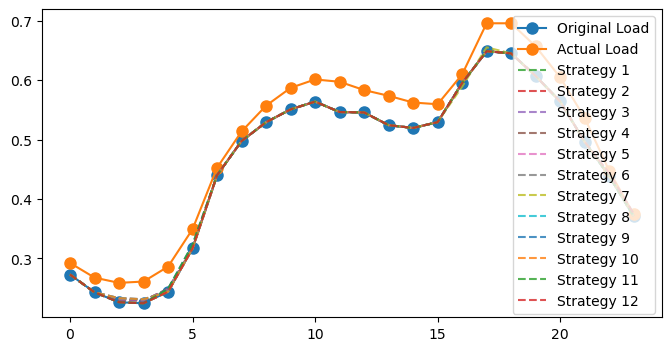

Found 1 relevant failed reflection cases for inquiry 24


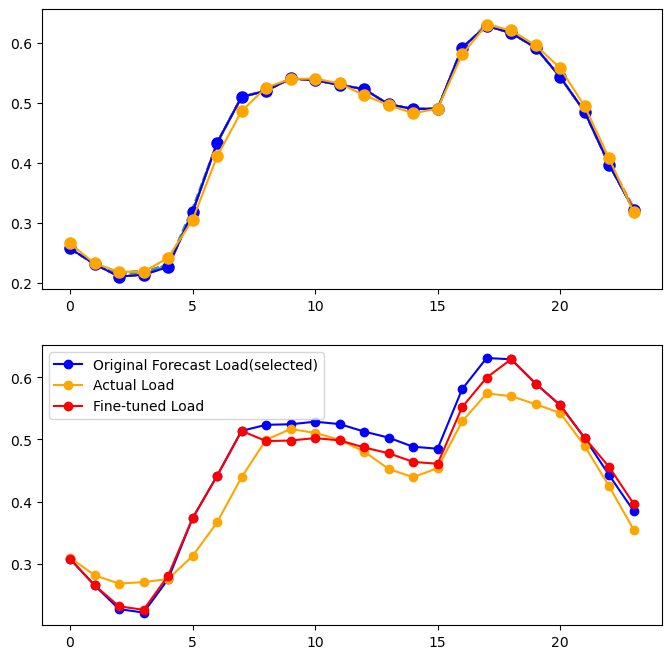

Original cost: 2631.4863002929687, Fine-tuned cost: 2591.329359916649
3177.2309113867186
3154.6839031247796


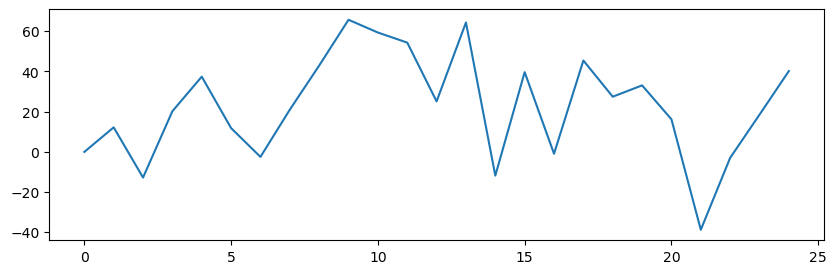

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 26/29
Found 3 similar days for inquiry 25
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2697.18, original cost 2702.94, (reduction 5.76)
Discovered valid strategy strategy_3, cost 2694.45, original cost 2702.94, (reduction 8.49)
Discovered valid strategy strategy_6, cost 2684.71, original cost 2702.94, (reduction 18.23)
Discovered valid strategy strategy_7, cost 2681.25, original cost 2702.94, (reduction 21.69)
Discovered valid strategy strategy_9, cost 2695.09, original cost 2702.94, (reduction 7.86)
Strategy generation attempt #2 (Current valid strategies: 5/20)
Discovered valid strategy strategy_1, cost 2697.18, origina

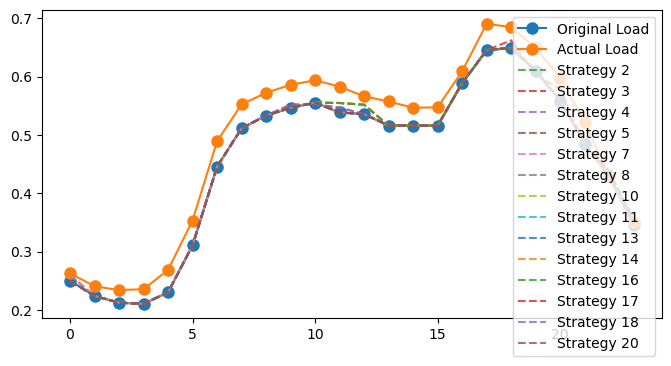

Found 1 relevant failed reflection cases for inquiry 25


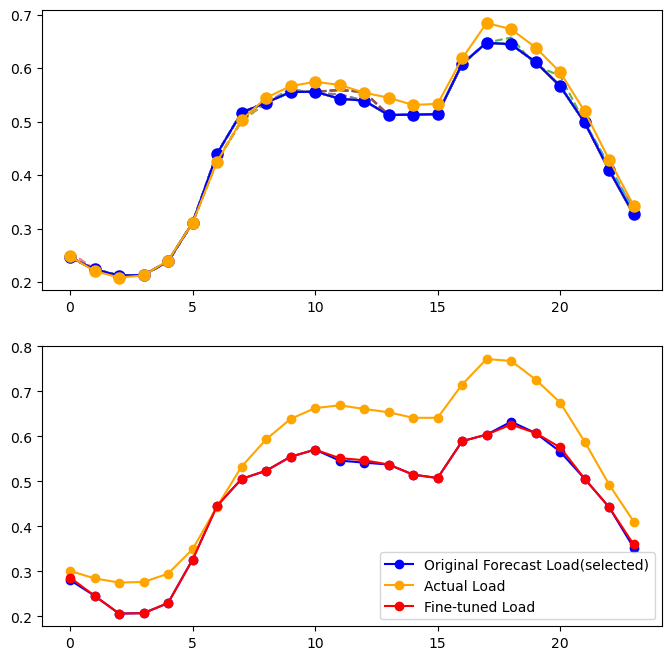

Original cost: 4071.462516113281, Fine-tuned cost: 4052.4858563491525
3211.6244346454328
3189.2147474795634


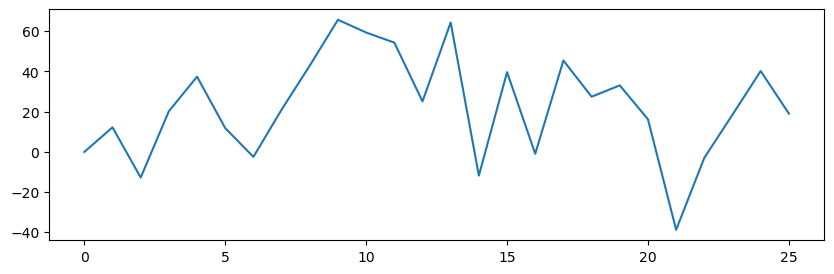

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 27/29
Found 3 similar days for inquiry 26
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_2, cost 2944.69, original cost 2961.55, (reduction 16.85)
Discovered valid strategy strategy_3, cost 2942.80, original cost 2961.55, (reduction 18.75)
Discovered valid strategy strategy_7, cost 2948.61, original cost 2961.55, (reduction 12.94)
Discovered valid strategy strategy_10, cost 2943.91, original cost 2961.55, (reduction 17.63)
Strategy generation attempt #2 (Current valid strategies: 4/20)
Discovered valid strategy strategy_3, cost 2942.80, original cost 2961.55, (reduction 18.75)
Discovered valid strategy strategy_6, cost 2948.61, ori

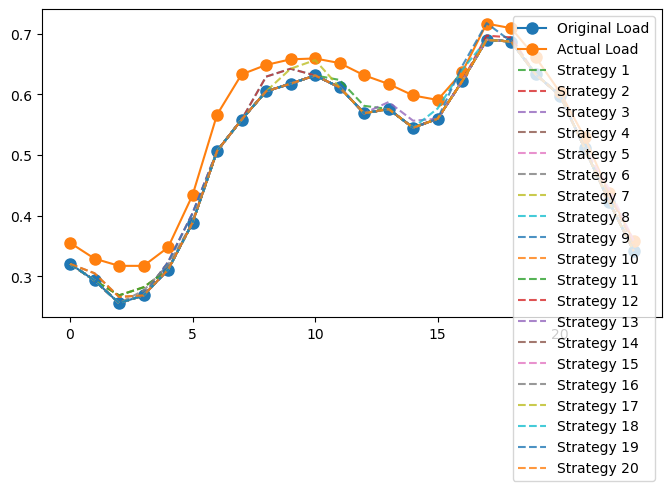

Found 1 relevant failed reflection cases for inquiry 26


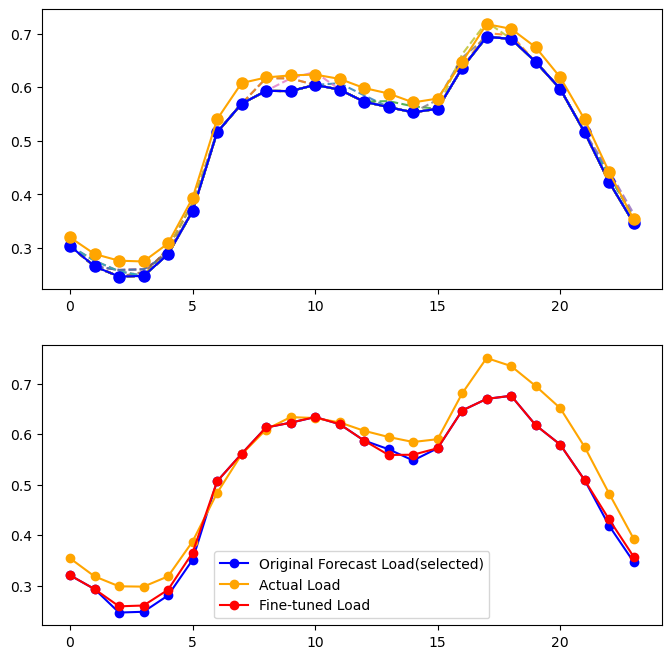

Original cost: 3221.8686674804685, Fine-tuned cost: 3169.860183867175
3212.00385067636
3188.4979117902153


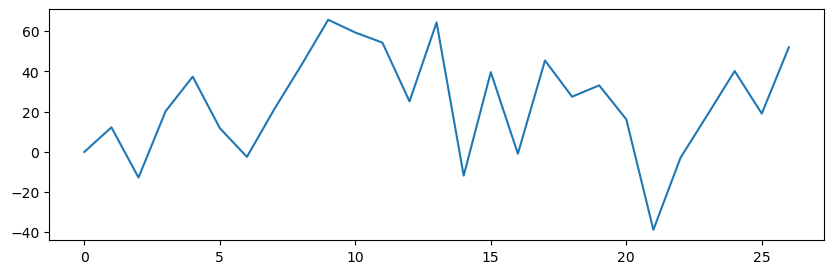

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 28/29
Found 3 similar days for inquiry 27
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_1, cost 2537.45, original cost 2547.99, (reduction 10.54)
Discovered valid strategy strategy_3, cost 2532.64, original cost 2547.99, (reduction 15.35)
Discovered valid strategy strategy_8, cost 2542.14, original cost 2547.99, (reduction 5.85)
Strategy generation attempt #2 (Current valid strategies: 3/20)
Discovered valid strategy strategy_1, cost 2537.45, original cost 2547.99, (reduction 10.54)
Discovered valid strategy strategy_3, cost 2532.64, original cost 2547.99, (reduction 15.35)
Discovered valid strategy strategy_6, cost 2543.49, origi

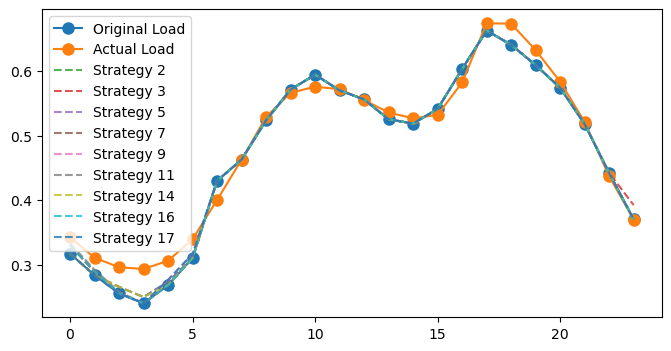

Found 1 relevant failed reflection cases for inquiry 27


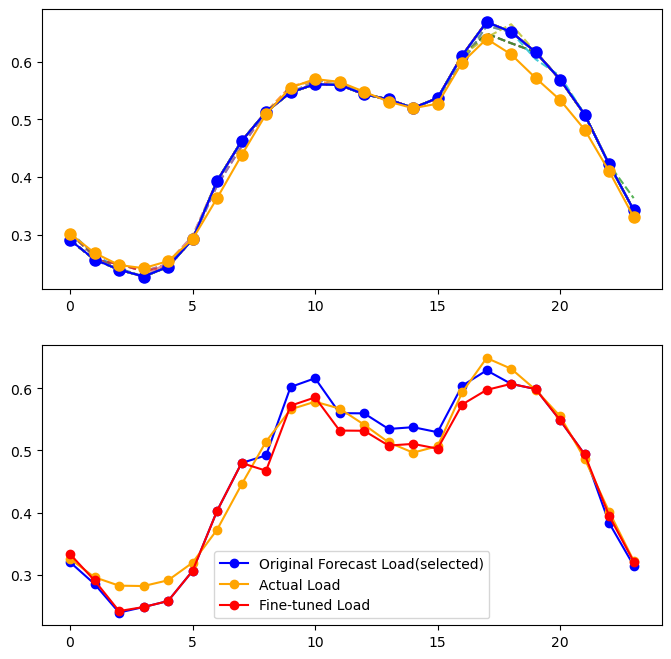

Original cost: 2680.726507324219, Fine-tuned cost: 2704.22799439016
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_3, cost 2666.28, original cost 2680.73, (reduction 14.45)
Discovered valid strategy strategy_4, cost 2659.06, original cost 2680.73, (reduction 21.67)
Discovered valid strategy strategy_7, cost 2669.49, original cost 2680.73, (reduction 11.24)
Discovered valid strategy strategy_9, cost 2671.44, original cost 2680.73, (reduction 9.29)
Strategy generation attempt #2 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_3, cost 2666.28, original cost 2680.73, (reduction 14.45)
3193.0296598423547
3171.2025575973566


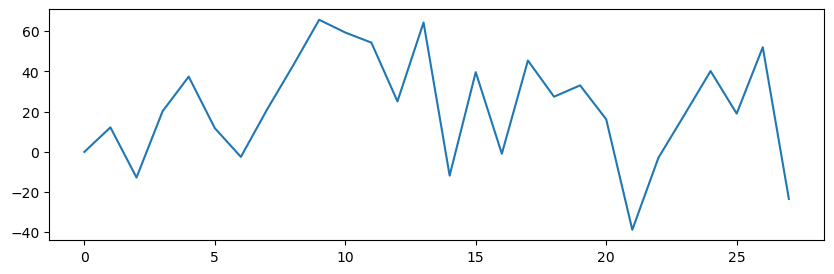

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []
Processing inquiry 29/29
Found 3 similar days for inquiry 28
Generating few-shot prompts based on similar days...
Strategy generation attempt #1 (Current valid strategies: 0/20)
Discovered valid strategy strategy_3, cost 2459.71, original cost 2473.13, (reduction 13.43)
Strategy generation attempt #2 (Current valid strategies: 1/20)
Discovered valid strategy strategy_3, cost 2459.71, original cost 2473.13, (reduction 13.43)
Discovered valid strategy strategy_6, cost 2471.37, original cost 2473.13, (reduction 1.76)
Discovered valid strategy strategy_8, cost 2464.88, original cost 2473.13, (reduction 8.26)
Strategy generation attempt #3 (Current valid strategies: 4/20)
Providing actual load values
Discovered valid strategy strategy_3, cost 2459.71, origin

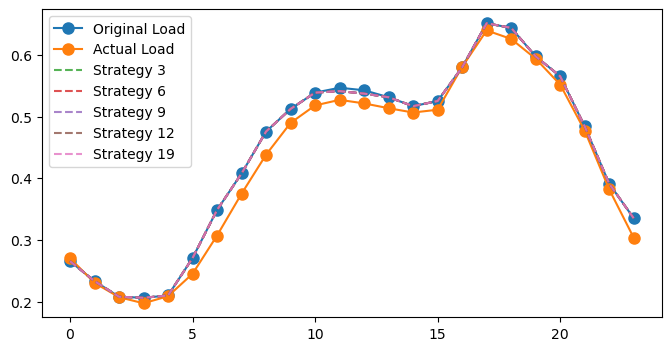

Found 1 relevant failed reflection cases for inquiry 28


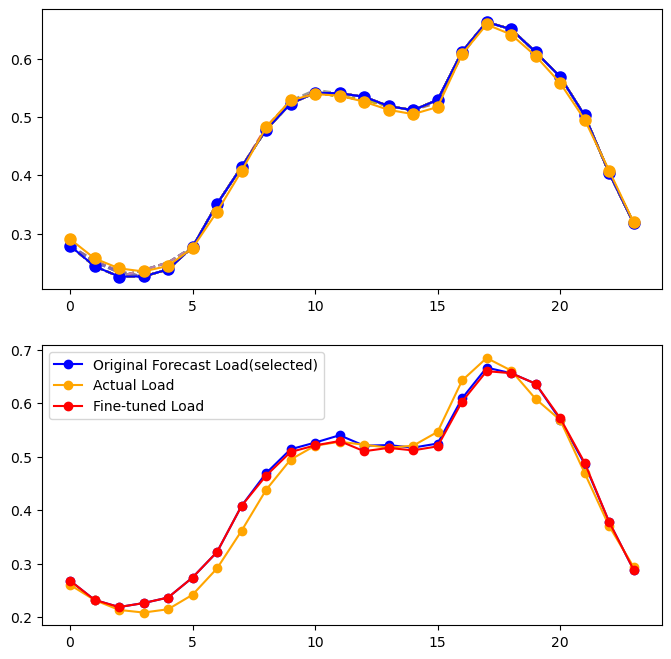

Original cost: 2503.5631875000004, Fine-tuned cost: 2520.7983236668215
Strategy generation attempt #1 (Current valid strategies: 0/5)
Discovered valid strategy strategy_1, cost 2498.94, original cost 2503.56, (reduction 4.62)
Discovered valid strategy strategy_5, cost 2498.48, original cost 2503.56, (reduction 5.08)
Discovered valid strategy strategy_6, cost 2502.41, original cost 2503.56, (reduction 1.16)
Discovered valid strategy strategy_7, cost 2501.84, original cost 2503.56, (reduction 1.72)
Strategy generation attempt #2 (Current valid strategies: 4/5)
Providing actual load values
Discovered valid strategy strategy_1, cost 2498.94, original cost 2503.56, (reduction 4.62)
3169.2549538995145
3148.7748253928553


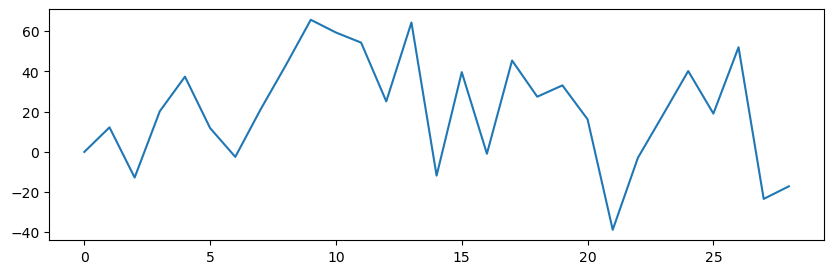

The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: []
The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: []


In [ ]:
fine_tuned_result_given_by_LLM = {
    'selected_flag': [], 'original_load': [], 'optnet_load': [], 'fine_tuned_load': [], 
    'cost_org': [], 'cost_optnet': [], 'cost_after': [], 'actual_load': [],
    'few_shot_curves': [], 'few_shot_costs': [], 'few_shot_code': [], 
    'similar_load': [], 'similar_actual_load': [], 'strategy_code': []
}

skip_samples = []
validate_failures = []
reflection_records = []

for inqure_id in range(len(forecasts_load_test_insert)):
    print(f"Processing inquiry {inqure_id+1}/{len(forecasts_load_test_insert)}")
    data_for_inqure = {
        'load': forecasts_load_test_insert[inqure_id],
    }

    similar_days = db_train.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_org = np.mean([day['load'] for day in similar_days], axis=0)
    average_similar_load_actual = np.mean([day['actual_load'] for day in similar_days], axis=0)
    average_similar_load_org_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_org).reshape(1,-1))[0]
    average_similar_load_actual_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual).reshape(1,-1))[0]
    _, _, obj_org_similar_days = optimization_module.forward(average_similar_load_org_numpy, average_similar_load_actual_numpy)
    obj_org_similar_days = obj_org_similar_days.item()

    selected_flag = 'org'
    load_nor = data_for_inqure['load']
    average_similar_load = average_similar_load_org
    actual_load_numpy = train_load_data.scaler_y.inverse_transform(np.array(actual_load_test_insert[inqure_id]).reshape(1,-1))[0]
    load_numpy_org = train_load_data.scaler_y.inverse_transform(np.array(data_for_inqure['load']).reshape(1,-1))[0]
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    higher_flag = "higher" if sum(np.array(average_similar_load) - np.array(average_similar_load_actual)) > 0 else "lower"
    reduce_flag = "reduce" if higher_flag == "higher" else "increase"
    print(f"Found {len(similar_days)} similar days for inquiry {inqure_id}")
    
    system_prompt = generate_prompt_sys(args, data_for_inqure)

    full_user_prompt = f"SYSTEM INSTRUCTIONS:\n{system_prompt}."
    full_user_prompt += f"""\n\nHint: You have two approaches to reduce cost:  

    1. Compare the actual value and forecast of the similar day, try to learn some error reduction strategies. In historical similar days, we found the forecasts were {higher_flag} than actual, so you can try to {reduce_flag} the load in some hours to reduce cost.  
    2. Compare the future positive and negative reserve prices.  
    - If the positive reserve price is much higher than the negative reserve price, you should schedule more generation in the day-ahead market.  
    - If the negative reserve price is higher, schedule less generation to reduce potential costs.  
    """

    # Few-shot code integration
    print("Generating few-shot prompts based on similar days...")
    strategy_history, valid_strategies = few_shot_prompt_generate(args, similar_days, max_strategies=20, max_attempts=6)
    
    # Validate strategies on validation set
    selected_strategy = []
    similar_days_val = db_val.get_top_k_unique_loads(data_for_inqure['load'], k=3, q=1)[0:3]
    average_similar_load_val = np.mean([day['load'] for day in similar_days_val], axis=0)
    average_similar_load_actual_val = np.mean([day['actual_load'] for day in similar_days_val], axis=0)
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(average_similar_load_val)), average_similar_load_val, markersize=8, marker='o', label='Original Load')
    plt.plot(range(len(average_similar_load_val)), average_similar_load_actual_val, markersize=8, marker='o', label='Actual Load')
    
    load_nor_val = average_similar_load_val.tolist()
    load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(load_nor_val).reshape(1,-1))[0]
    actual_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(average_similar_load_actual_val).reshape(1,-1))[0]

    for strategy in valid_strategies:
        strategy_result = evaluate_individual_strategies(
            strategy['code'],
            load_nor_val,
            max_change_percent=0.1
        )
        selected_curve_val = strategy_result[list(strategy_result.keys())[0]]['adjusted_curve']

        fine_tune_load_val_numpy = train_load_data.scaler_y.inverse_transform(np.array(selected_curve_val).reshape(1,-1))[0]
        _, _, obj_org_val = optimization_module.forward(load_val_numpy, actual_load_val_numpy)
        _, _, obj_fine_tune_val = optimization_module.forward(fine_tune_load_val_numpy, actual_load_val_numpy)

        if obj_org_val > obj_fine_tune_val:
            selected_strategy.append(strategy)
            plt.plot(range(24), selected_curve_val, label=strategy['name'], linestyle='--', alpha=0.8)
            print(f"Strategy {strategy['name']} succeeded on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (reduction {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
        else:
            print(f"Strategy {strategy['name']} failed on validation set, cost {obj_fine_tune_val.item():.2f}, original cost {obj_org_val.item():.2f}, (increase {obj_org_val.item()-obj_fine_tune_val.item():.2f})")
    plt.legend()
    plt.show()

    # Skip if no valid fine-tuning strategies found
    if len(selected_strategy) == 0:
        print(f"Inquiry {inqure_id}: No valid strategy found, using original curve as fine-tuned result.")
        _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)

        fine_tuned_result_given_by_LLM['fine_tuned_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['cost_after'].append(obj_org.item())

        fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
        fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
        fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
        fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
        fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
        fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
        fine_tuned_result_given_by_LLM['few_shot_costs'].append([])
        fine_tuned_result_given_by_LLM['few_shot_curves'].append([])
        fine_tuned_result_given_by_LLM['few_shot_code'].append([])
        fine_tuned_result_given_by_LLM['strategy_code'].append('')
        skip_samples.append(inqure_id)
        # Visualization
        if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
            print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
            print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
            plt.figure(figsize=(8, 3))
            plt.plot(
                range(len(fine_tuned_result_given_by_LLM['cost_org'])),
                np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
                label='Compared to original'
            )
            plt.show()
            plt.close()
        continue

    # Build few-shot LLM prompt
    few_shot_costs = [s['final_cost'] for s in selected_strategy]
    few_shot_curves = [s['adjusted_curve'] for s in selected_strategy]
    few_shot_codes = [s['code'] for s in selected_strategy]
    history_snippet_prompt = 'Here are some previously discovered effective adjustment strategies:\n'
    for i, s in enumerate(selected_strategy):
        history_snippet_prompt += f"Good strategy {i+1} from few-shot:\n{s['code']}\n\n"
    history_snippet_prompt += f"You should ensemble these strategies as you can only output one adjustment_strategy function.\n"

    last_fail_reflections = get_fail_reflections_by_curve_distance(reflection_records, data_for_inqure['load'], max_num=1)
    print(f"Found {len(last_fail_reflections)} relevant failed reflection cases for inquiry {inqure_id}")
    fail_reflections_prompt = ""
    if last_fail_reflections:
        fail_reflections_prompt = 'You have failed in these examples and led to cost increase, avoid these patterns:\n'
        fail_reflections_prompt += "\n### Previous failed adjustment text (avoid these patterns):\n"
        for idx, record in enumerate(last_fail_reflections):
            fail_reflections_prompt += (
                f"Fail Case {idx + 1}:\n"
                f"- Last failed strategy:\n{remove_comments(record['strategy_code'])}\n\n"
                f"- Successful strategy:\n{(record['reflection_strategy'])}\n\n"
            )

    if args.LLM_type == 'Qwen':
        response = Generation.call(
            model="qwen-plus",
            messages=[
                {"role": "user", "content": output_require_prompt},
                {"role": "assistant", "content": history_snippet_prompt},
                {"role": "assistant", "content": fail_reflections_prompt},
            ],
            parameters={
                "temperature": 0.1,
                "result_format": "text",
                "max_tokens": 2048,
                "top_k": 10
            }
        )
        raw_text = response.output.text.strip()
        func_code = extract_pure_code(raw_text)
      
    elif args.LLM_type == 'Deepseek':
        client = OpenAI(api_key=DEEPSEEK_API_KEY,
                base_url="https://api.deepseek.com")
        response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        stream=False,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
        
    elif args.LLM_type=='Llama':
        client = Together(api_key=LLAMA_API_KEY)
        response = client.chat.completions.create(
            model="meta-llama/Llama-4-Scout-17B-16E-Instruct",  # 可替换为其他 Llama 版本
            messages=[
            {"role": "system", "content": full_user_prompt},
            {"role": "user", "content": output_require_prompt},
            {"role": "assistant", "content": history_snippet_prompt},
            {"role": "assistant", "content": fail_reflections_prompt},
        ],
        temperature=0.1,
        max_tokens=2048,
        )
        raw_text = response.choices[0].message.content.strip()
        func_code = extract_pure_code(raw_text)
    

    if selected_flag == 'org':
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['load'],
            max_change_percent=0.1
        )
    else:
        selected_curve, delta_curve, strategy_code = execute_strategy_function(
            func_code,
            data_for_inqure['fine_tuned_load'],
            max_change_percent=0.1
        )


    fine_tune_load_numpy =  train_load_data.scaler_y.inverse_transform(np.array(selected_curve).reshape(1, -1))[0]
    _, _, obj_org = optimization_module.forward(load_numpy_org, actual_load_numpy)
    _, _, obj_fine_tune = optimization_module.forward(fine_tune_load_numpy, actual_load_numpy)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    for i in valid_strategies:
        plt.plot(i['adjusted_curve'], label=i['name'], linestyle='--', alpha=0.8)
    if selected_flag == 'org':
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Original Load', color='blue')
    else:
        plt.plot(range(24), i['original_load'], markersize=8, marker='o', label='Optnet Load', color='green')
    plt.plot(range(24), i['actual_load'], markersize=8, marker='o', label='Actual Load', color='orange')
    # plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(range(24), data_for_inqure['load'], label='Original Forecast Load(selected)', marker='o', color='blue')
    plt.plot(range(24), actual_load_test_insert[inqure_id], label='Actual Load', marker='o', color='orange')
    plt.plot(range(24), selected_curve, label='Fine-tuned Load', marker='o', color='red')
    plt.legend()
    plt.show()
    print(f"Original cost: {obj_org.item()}, Fine-tuned cost: {obj_fine_tune.item()}")

    if selected_flag == 'org' and obj_fine_tune.item() < obj_org.item():
            reflection_strategy = "Cost reduction achieved."
            insight = f"Successfully reduced cost by {obj_org.item() - obj_fine_tune.item():.2f}."
    elif selected_flag == 'org' and obj_fine_tune.item() > obj_org.item():
        failures = [{
            "inqure_id": inqure_id,
            "load": data_for_inqure['load'],
            "actual_load": actual_load_test_insert[inqure_id],
            'fine_tuned_load': selected_curve,
            "cost_before": obj_org.item(),
            "cost_after": obj_fine_tune.item(),
            "strategy_code": strategy_code,
        }]

        reflection_strategy_history, reflection_valid_strategies = few_shot_prompt_generate(args, failures, max_strategies=5, max_attempts=3,failure_strategy=strategy_code)
        reflection_strategy = f"For this failure case, consider:"
        for i in range(len(reflection_valid_strategies)):
            strategy = reflection_valid_strategies[i]
            reflection_strategy += f"Successful strategy {i} for failure case:\n{remove_comments(strategy['code'])}\n"

    reflection_records.append({
        "inquiry_id": inqure_id,
        "original_load": data_for_inqure['load'],
        "actual_load": actual_load_test_insert[inqure_id],
        "fine_tuned_load": selected_curve,
        "cost_before": obj_org.item(),
        "cost_after": obj_fine_tune.item(),
        "strategy_code": strategy_code,
        "reflection_strategy": reflection_strategy,
        "similar_day_comparison": f"Similar days showed forecast was {higher_flag} than actual"
    })
    reflection_records = reflection_records[-10:]  # Keep only last 10 records

    fine_tuned_result_given_by_LLM['selected_flag'].append(selected_flag)
    fine_tuned_result_given_by_LLM['actual_load'].append(actual_load_test_insert[inqure_id])
    fine_tuned_result_given_by_LLM['original_load'].append(data_for_inqure['load'])
    fine_tuned_result_given_by_LLM['fine_tuned_load'].append(selected_curve)
    fine_tuned_result_given_by_LLM['cost_after'].append(obj_fine_tune.item())
    fine_tuned_result_given_by_LLM['cost_org'].append(obj_org.item())
    fine_tuned_result_given_by_LLM['similar_load'].append(average_similar_load.tolist())
    fine_tuned_result_given_by_LLM['similar_actual_load'].append(average_similar_load_actual.tolist())
    fine_tuned_result_given_by_LLM['few_shot_costs'].append(few_shot_costs)
    fine_tuned_result_given_by_LLM['few_shot_curves'].append(few_shot_curves)
    fine_tuned_result_given_by_LLM['few_shot_code'].append(few_shot_codes)
    fine_tuned_result_given_by_LLM['strategy_code'].append(strategy_code)

    if len(fine_tuned_result_given_by_LLM['cost_org']) > 1:
        print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
        print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))
        plt.figure(figsize=(10, 3))
        plt.plot(
            range(len(fine_tuned_result_given_by_LLM['cost_org'])),
            np.array(fine_tuned_result_given_by_LLM['cost_org']) - np.array(fine_tuned_result_given_by_LLM['cost_after']),
            label='Compared to original'
        )
        plt.show()
        plt.close()

    print(f"The following samples (inqure_id) did not complete LLM fine-tuning and used the original forecast curve: {skip_samples}")
    print(f"The following samples (inqure_id) failed to find a valid strategy on the validation set and used the original forecast curve: {validate_failures}")

    with open('../Result/Tree+LP/'+args.LLM_type+'.pkl', 'wb') as f:
        pickle.dump(fine_tuned_result_given_by_LLM, f)

### result

In [51]:
print(np.mean(cost_list_ideal))
print(np.mean(fine_tuned_result_given_by_LLM['cost_org']))
print(np.mean(fine_tuned_result_given_by_LLM['cost_after']))

2523.7132413793106
3169.2549538995145
3148.7748253928553
